In [6]:
import matplotlib.pyplot as plt
import seaborn as sns; 
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.svm import SVC

sns.set(rc={'figure.figsize':(11.7,8.27)})

pd_csv = '../../data/pd_speech_features.csv'

In [7]:
def get_data(path):
  data = pd.read_csv(path, header=1)
  return data

def cor_heat(data, annot=False):
  corr = data.corr()
  sns.heatmap(corr, cmap='coolwarm_r', annot=annot)
  plt.show()

def split_data(data, scale=False, test_size=0.2):
  X = data.drop(data.columns[-1], axis=1)
  y = data[data.columns[-1]]

  if scale:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=387)
  return X_train, X_test, y_train, y_test

def scale(data):
  X = data.drop(data.columns[-1], axis=1)
  y = data[data.columns[-1]]

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  return pd.concat([X, y])

def hist(data, columns):

  if len(columns) > 1:
    _, ax = plt.subplots(1, len(columns), figsize=(30,10))
    for i in range(len(columns)):
      sns.histplot(data=data, x=columns[i], ax=ax[i])

  elif len(columns) == 1:
    sns.histplot(data=data, x=columns[0])

def evaluate_data(data):
  display(data.head())
  print('Null values:', data.isnull().sum().sum())
  pd.set_option('display.max_columns', None)
  display(data.describe())
  pd.reset_option('display.max_columns')

def remove_outliers(data, iqr_multiplier = 1.5, skip_columns = []):
  ret_data = data.copy()
  for column in ret_data.columns:
    if len(ret_data) == 0:
      break
    elif column in skip_columns:
      continue
    print(column)

    print('\tBefore removal:', len(ret_data))
    q25, q75 = np.percentile(ret_data, 25), np.percentile(ret_data, 75)
    iqr = q75 - q25

    cut_off = iqr * iqr_multiplier
    lower, upper = q25 - cut_off, q75 + cut_off

    ret_data =  ret_data.drop(ret_data[(ret_data[column] > upper) | (ret_data[column] < lower)].index)
    print('\tAfter removal: {}'.format(len(ret_data)))
  return ret_data

def remove_outliers_2(data, lower, upper):
  lower_percentile = data.quantile(lower)
  upper_percentile = data.quantile(upper)
  
  ret_data = data[(data >= lower_percentile) & (data <= upper_percentile)].dropna()
  
  return ret_data

def evaluate_model(y_test, y_pred, labels):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)
  print("ROC AUC Score:", roc_auc, '\n')

  cr = classification_report(y_test, y_pred, target_names=labels, zero_division=0)
  print(cr)
  
  cm = confusion_matrix(y_test, y_pred)

  true_positives = cm[1, 1]
  false_negatives = cm[1, 0]
  positive_recall = true_positives / (true_positives + false_negatives)
  print('Positive Recall:', positive_recall)
  
  sns.heatmap(cm.T, square=True, annot=True, fmt='d', xticklabels = labels, yticklabels = labels)
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  plt.show()

def evaluate_models(data, models):
  # Preprocessing and Standardization
  X_train, X_test, y_train, y_test = split_data(data, scale=True)

  for model in models:
    # print(re.findall(r'\.(.*)', type(model)))

    print('\n\t~~~~\t', type(model).__name__, '\t~~~~\n')
    # Train the model
    model.fit(X_train, y_train)

    # Measure Model 
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    evaluate_model(y_test, y_pred, ['Negative', 'Positive'])

def get_important(data, top=20):
  X = data.drop(data.columns[-1], axis=1)
  y = data[data.columns[-1]]

  rf = RandomForestClassifier()
  rf.fit(X, y)

  feature_importances = rf.feature_importances_

  sorted_indices = np.argsort(feature_importances)[::-1]
  sorted_indices = sorted_indices[:top]
  
  selected_feature_names = X.columns[sorted_indices]
  selected_columns = np.concatenate([selected_feature_names, [data.columns[-1]]])
 
  selected_data = data[selected_columns]
  return selected_data

def get_pca(data, components):
  X = data.drop(data.columns[-1], axis=1)
  y = data[data.columns[-1]]

  pca = PCA(n_components=components)
  transformed_data = pca.fit_transform(X)

  transformed_df = pd.DataFrame(transformed_data, columns=[f"component_{i+1}" for i in range(components)])
  transformed_df['target'] = y.values

  return transformed_df


In [8]:
pd_data = get_data(pd_csv)
evaluate_data(pd_data)
print(pd_data['class'].value_counts())
print(round(pd_data['class'].value_counts()[1]/(pd_data['class'].value_counts()[0] + pd_data['class'].value_counts()[1] )* 100, 2), '% pd')
print('\n', pd_data.groupby('id')['class'].sum())


,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


Null values: 0


,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,GNE_NSR_TKEO,GNE_NSR_SEO,VFER_mean,VFER_std,VFER_entropy,VFER_SNR_TKEO,VFER_SNR_SEO,VFER_NSR_TKEO,VFER_NSR_SEO,IMF_SNR_SEO,IMF_SNR_TKEO,IMF_SNR_entropy,IMF_NSR_SEO,IMF_NSR_TKEO,IMF_NSR_entropy,mean_Log_energy,mean_MFCC_0th_coef,mean_MFCC_1st_coef,mean_MFCC_2nd_coef,mean_MFCC_3rd_coef,mean_MFCC_4th_coef,mean_MFCC_5th_coef,mean_MFCC_6th_coef,mean_MFCC_7th_coef,mean_MFCC_8th_coef,mean_MFCC_9th_coef,mean_MFCC_10th_coef,mean_MFCC_11th_coef,mean_MFCC_12th_coef,mean_delta_log_energy,mean_0th_delta,mean_1st_delta,mean_2nd_delta,mean_3rd_delta,mean_4th_delta,mean_5th_delta,mean_6th_delta,mean_7th_delta,mean_8th_delta,mean_9th_delta,mean_10th_delta,mean_11th_delta,mean_12th_delta,mean_delta_delta_log_energy,mean_delta_delta_0th,mean_1st_delta_delta,mean_2nd_delta_delta,mean_3rd_delta_delta,mean_4th_delta_delta,mean_5th_delta_delta,mean_6th_delta_delta,mean_7th_delta_delta,mean_8th_delta_delta,mean_9th_delta_delta,mean_10th_delta_delta,mean_11th_delta_delta,mean_12th_delta_delta,std_Log_energy,std_MFCC_0th_coef,std_MFCC_1st_coef,std_MFCC_2nd_coef,std_MFCC_3rd_coef,std_MFCC_4th_coef,std_MFCC_5th_coef,std_MFCC_6th_coef,std_MFCC_7th_coef,std_MFCC_8th_coef,std_MFCC_9th_coef,std_MFCC_10th_coef,std_MFCC_11th_coef,std_MFCC_12th_coef,std_delta_log_energy,std_0th_delta,std_1st_delta,std_2nd_delta,std_3rd_delta,std_4th_delta,std_5th_delta,std_6th_delta,std_7th_delta,std_8th_delta,std_9th_delta,std_10th_delta,std_11th_delta,std_12th_delta,std_delta_delta_log_energy,std_delta_delta_0th,std_1st_delta_delta,std_2nd_delta_delta,std_3rd_delta_delta,std_4th_delta_delta,std_5th_delta_delta,std_6th_delta_delta,std_7th_delta_delta,std_8th_delta_delta,std_9th_delta_delta,std_10th_delta_delta,std_11th_delta_delta,std_12th_delta_delta,Ea,Ed_1_coef,Ed_2_coef,Ed_3_coef,Ed_4_coef,Ed_5_coef,Ed_6_coef,Ed_7_coef,Ed_8_coef,Ed_9_coef,Ed_10_coef,det_entropy_shannon_1_coef,det_entropy_shannon_2_coef,det_entropy_shannon_3_coef,det_entropy_shannon_4_coef,det_entropy_shannon_5_coef,det_entropy_shannon_6_coef,det_entropy_shannon_7_coef,det_entropy_shannon_8_coef,det_entropy_shannon_9_coef,det_entropy_shannon_10_coef,det_entropy_log_1_coef,det_entropy_log_2_coef,det_entropy_log_3_coef,det_entropy_log_4_coef,det_entropy_log_5_coef,det_entropy_log_6_coef,det_entropy_log_7_coef,det_entropy_log_8_coef,det_entropy_log_9_coef,det_entropy_log_10_coef,det_TKEO_mean_1_coef,det_TKEO_mean_2_coef,det_TKEO_mean_3_coef,det_TKEO_mean_4_coef,det_TKEO_mean_5_coef,det_TKEO_mean_6_coef,det_TKEO_mean_7_coef,det_TKEO_mean_8_coef,det_TKEO_mean_9_coef,det_TKEO_mean_10_coef,det_TKEO_std_1_coef,det_TKEO_std_2_coef,det_TKEO_std_3_coef,det_TKEO_std_4_coef,det_TKEO_std_5_coef,det_TKEO_std_6_coef,det_TKEO_std_7_coef,det_TKEO_std_8_coef,det_TKEO_std_9_coef,det_TKEO_std_10_coef,app_entropy_shannon_1_coef,app_entropy_shannon_2_coef,app_entropy_shannon_3_coef,app_entropy_shannon_4_coef,app_entropy_shannon_5_coef,app_entropy_shannon_6_coef,app_entropy_shannon_7_coef,app_entropy_shannon_8_coef,app_entropy_shannon_9_coef,app_entropy_shannon_10_coef,app_entropy_log_1_coef,app_entropy_log_2_coef,app_entropy_log_3_coef,app_entropy_log_4_coef,app_entropy_log_5_coef,app_entropy_log_6_coef,app_entropy_log_7_coef,app_entropy_log_8_coef,app_entropy_log_9_coef,app_entropy_log_10_coef,app_det_TKEO_mean_1_coef,app_det_TKEO_mean_2_coef,app_det_TKEO_mean_3_coef,app_det_TKEO_mean_4_coef,app_det_TKEO_mean_5_coef,app_det_TKEO_mean_6_coef,app_det_TKEO_mean_7_coef,app_det_TKEO_mean_8_coef,app_det_TKEO_mean_9_coef,app_det_TKEO_mean_10_coef,app_TKEO_std_1_coef,app_TKEO_std_2_coef,app_TKEO_

class
1    564
0    192
Name: count, dtype: int64
74.6 % pd

 id
0      3
1      3
2      3
3      3
4      3
      ..
247    3
248    3
249    3
250    0
251    0
Name: class, Length: 252, dtype: int64


There seems to be 3 entries for each id value. Regardless this feature should be removed.<br>
There are also a lot of features with a lot of different deviations. The data should be normalized.

In [19]:
pd_data = get_data(pd_csv)
pd_data = pd_data.drop(['id'], axis=1)
remove_outliers(pd_data, skip_columns=[], iqr_multiplier=5)

gender
	Before removal: 756
	After removal: 756
PPE
	Before removal: 756
	After removal: 756
DFA
	Before removal: 756
	After removal: 756
RPDE
	Before removal: 756
	After removal: 756
numPulses
	Before removal: 756
	After removal: 1
numPeriodsPulses
	Before removal: 1
	After removal: 1
meanPeriodPulses
	Before removal: 1
	After removal: 1
stdDevPeriodPulses
	Before removal: 1
	After removal: 1
locPctJitter
	Before removal: 1
	After removal: 1
locAbsJitter
	Before removal: 1
	After removal: 1
rapJitter
	Before removal: 1
	After removal: 1
ppq5Jitter
	Before removal: 1
	After removal: 1
ddpJitter
	Before removal: 1
	After removal: 1
locShimmer
	Before removal: 1
	After removal: 1
locDbShimmer
	Before removal: 1
	After removal: 1
apq3Shimmer
	Before removal: 1
	After removal: 1
apq5Shimmer
	Before removal: 1
	After removal: 1
apq11Shimmer
	Before removal: 1
	After removal: 1
ddaShimmer
	Before removal: 1
	After removal: 1
meanAutoCorrHarmonicity
	Before removal: 1
	After removal: 1
meanNo

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class


In [20]:
pd_data = get_data(pd_csv)
pd_data = pd_data.drop(['id'], axis=1)

df = pd.DataFrame(pd_data)

normalized_df = (df - df.mean()) / df.std()

z_score_threshold = 20

outliers_mask = (normalized_df.abs() > z_score_threshold).any(axis=1)
filtered_df = df[~outliers_mask]

print("Original DataFrame:")
print(len(df))

print("\nFiltered DataFrame (without outliers):")
print(len(filtered_df))

Original DataFrame:
756

Filtered DataFrame (without outliers):
739





		 *** ALL Features ***




	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.9342105263157895
Precision: 0.9512195121951219
Recall: 0.9669421487603306
F1 Score: 0.9590163934426229
ROC AUC Score: 0.8866968808317782 

              precision    recall  f1-score   support

    Negative       0.86      0.81      0.83        31
    Positive       0.95      0.97      0.96       121

    accuracy                           0.93       152
   macro avg       0.91      0.89      0.90       152
weighted avg       0.93      0.93      0.93       152

Positive Recall: 0.9669421487603306


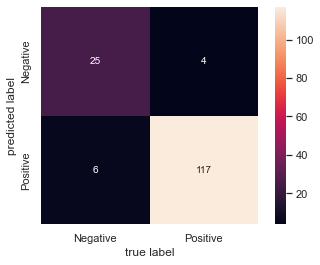


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8355263157894737
Precision: 0.9444444444444444
Recall: 0.8429752066115702
F1 Score: 0.890829694323144
ROC AUC Score: 0.8247134097573979 

              precision    recall  f1-score   support

    Negative       0.57      0.81      0.67        31
    Positive       0.94      0.84      0.89       121

    accuracy                           0.84       152
   macro avg       0.76      0.82      0.78       152
weighted avg       0.87      0.84      0.85       152

Positive Recall: 0.8429752066115702


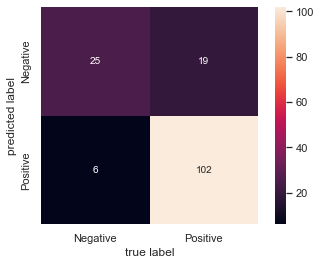


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.9539473684210527
Precision: 0.975
Recall: 0.9669421487603306
F1 Score: 0.970954356846473
ROC AUC Score: 0.9350839776059717 

              precision    recall  f1-score   support

    Negative       0.88      0.90      0.89        31
    Positive       0.97      0.97      0.97       121

    accuracy                           0.95       152
   macro avg       0.93      0.94      0.93       152
weighted avg       0.95      0.95      0.95       152

Positive Recall: 0.9669421487603306


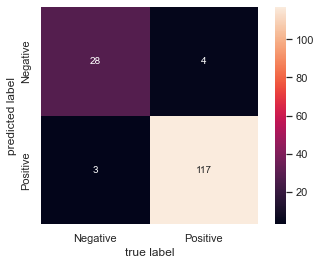


	~~~~	 SVC 	~~~~

Accuracy: 0.9078947368421053
Precision: 0.9083969465648855
Recall: 0.9834710743801653
F1 Score: 0.9444444444444445
ROC AUC Score: 0.7981871500933085 

              precision    recall  f1-score   support

    Negative       0.90      0.61      0.73        31
    Positive       0.91      0.98      0.94       121

    accuracy                           0.91       152
   macro avg       0.91      0.80      0.84       152
weighted avg       0.91      0.91      0.90       152

Positive Recall: 0.9834710743801653


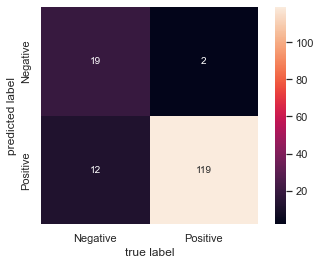


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.756578947368421
Precision: 0.9285714285714286
Recall: 0.7520661157024794
F1 Score: 0.8310502283105023
ROC AUC Score: 0.763129832044788 

              precision    recall  f1-score   support

    Negative       0.44      0.77      0.56        31
    Positive       0.93      0.75      0.83       121

    accuracy                           0.76       152
   macro avg       0.69      0.76      0.70       152
weighted avg       0.83      0.76      0.78       152

Positive Recall: 0.7520661157024794


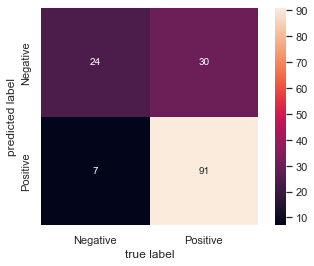




		 *** TOP 50 Features ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.9407894736842105
Precision: 0.9666666666666667
Recall: 0.9586776859504132
F1 Score: 0.9626556016597511
ROC AUC Score: 0.9148227139429485 

              precision    recall  f1-score   support

    Negative       0.84      0.87      0.86        31
    Positive       0.97      0.96      0.96       121

    accuracy                           0.94       152
   macro avg       0.91      0.91      0.91       152
weighted avg       0.94      0.94      0.94       152

Positive Recall: 0.9586776859504132


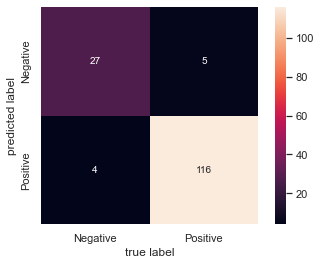


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.9013157894736842
Precision: 0.9491525423728814
Recall: 0.9256198347107438
F1 Score: 0.9372384937238494
ROC AUC Score: 0.8660357238069848 

              precision    recall  f1-score   support

    Negative       0.74      0.81      0.77        31
    Positive       0.95      0.93      0.94       121

    accuracy                           0.90       152
   macro avg       0.84      0.87      0.85       152
weighted avg       0.91      0.90      0.90       152

Positive Recall: 0.9256198347107438


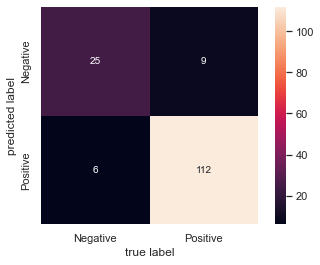


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.9407894736842105
Precision: 0.9745762711864406
Recall: 0.9504132231404959
F1 Score: 0.9623430962343097
ROC AUC Score: 0.9268195147960544 

              precision    recall  f1-score   support

    Negative       0.82      0.90      0.86        31
    Positive       0.97      0.95      0.96       121

    accuracy                           0.94       152
   macro avg       0.90      0.93      0.91       152
weighted avg       0.94      0.94      0.94       152

Positive Recall: 0.9504132231404959


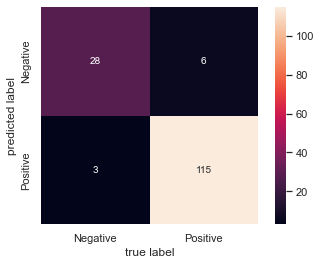


	~~~~	 SVC 	~~~~

Accuracy: 0.9276315789473685
Precision: 0.9508196721311475
Recall: 0.9586776859504132
F1 Score: 0.9547325102880658
ROC AUC Score: 0.8825646494268194 

              precision    recall  f1-score   support

    Negative       0.83      0.81      0.82        31
    Positive       0.95      0.96      0.95       121

    accuracy                           0.93       152
   macro avg       0.89      0.88      0.89       152
weighted avg       0.93      0.93      0.93       152

Positive Recall: 0.9586776859504132


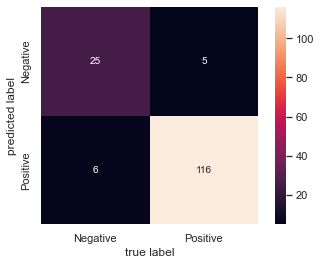


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.875
Precision: 0.9553571428571429
Recall: 0.8842975206611571
F1 Score: 0.9184549356223176
ROC AUC Score: 0.861503599040256 

              precision    recall  f1-score   support

    Negative       0.65      0.84      0.73        31
    Positive       0.96      0.88      0.92       121

    accuracy                           0.88       152
   macro avg       0.80      0.86      0.83       152
weighted avg       0.89      0.88      0.88       152

Positive Recall: 0.8842975206611571


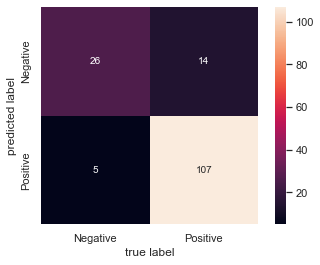




		 *** TOP 100 Features ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.9605263157894737
Precision: 0.9752066115702479
Recall: 0.9752066115702479
F1 Score: 0.9752066115702479
ROC AUC Score: 0.9392162090109303 

              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90        31
    Positive       0.98      0.98      0.98       121

    accuracy                           0.96       152
   macro avg       0.94      0.94      0.94       152
weighted avg       0.96      0.96      0.96       152

Positive Recall: 0.9752066115702479


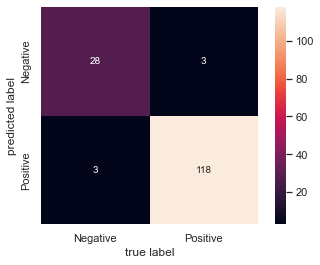


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.9078947368421053
Precision: 0.9652173913043478
Recall: 0.9173553719008265
F1 Score: 0.940677966101695
ROC AUC Score: 0.8941615569181551 

              precision    recall  f1-score   support

    Negative       0.73      0.87      0.79        31
    Positive       0.97      0.92      0.94       121

    accuracy                           0.91       152
   macro avg       0.85      0.89      0.87       152
weighted avg       0.92      0.91      0.91       152

Positive Recall: 0.9173553719008265


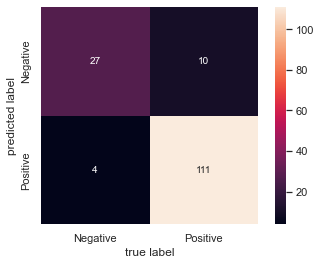


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.9342105263157895
Precision: 0.9586776859504132
Recall: 0.9586776859504132
F1 Score: 0.9586776859504132
ROC AUC Score: 0.898693681684884 

              precision    recall  f1-score   support

    Negative       0.84      0.84      0.84        31
    Positive       0.96      0.96      0.96       121

    accuracy                           0.93       152
   macro avg       0.90      0.90      0.90       152
weighted avg       0.93      0.93      0.93       152

Positive Recall: 0.9586776859504132


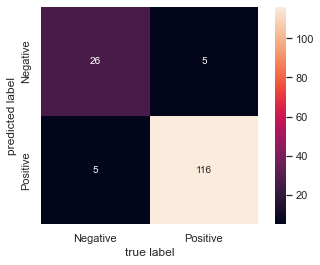


	~~~~	 SVC 	~~~~

Accuracy: 0.9342105263157895
Precision: 0.9743589743589743
Recall: 0.9421487603305785
F1 Score: 0.9579831932773109
ROC AUC Score: 0.9226872833910957 

              precision    recall  f1-score   support

    Negative       0.80      0.90      0.85        31
    Positive       0.97      0.94      0.96       121

    accuracy                           0.93       152
   macro avg       0.89      0.92      0.90       152
weighted avg       0.94      0.93      0.94       152

Positive Recall: 0.9421487603305785


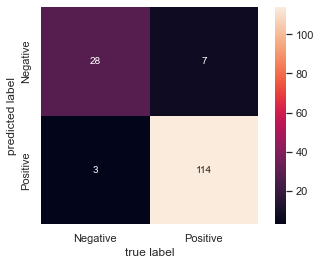


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.9276315789473685
Precision: 0.9583333333333334
Recall: 0.9504132231404959
F1 Score: 0.9543568464730291
ROC AUC Score: 0.8945614502799255 

              precision    recall  f1-score   support

    Negative       0.81      0.84      0.83        31
    Positive       0.96      0.95      0.95       121

    accuracy                           0.93       152
   macro avg       0.89      0.89      0.89       152
weighted avg       0.93      0.93      0.93       152

Positive Recall: 0.9504132231404959


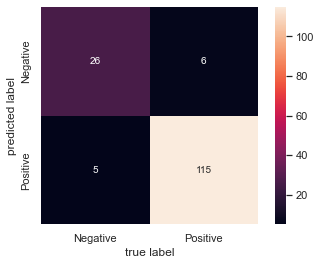




		 *** TOP 150 Features ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.9407894736842105
Precision: 0.9827586206896551
Recall: 0.9421487603305785
F1 Score: 0.9620253164556961
ROC AUC Score: 0.9388163156491602 

              precision    recall  f1-score   support

    Negative       0.81      0.94      0.87        31
    Positive       0.98      0.94      0.96       121

    accuracy                           0.94       152
   macro avg       0.89      0.94      0.91       152
weighted avg       0.95      0.94      0.94       152

Positive Recall: 0.9421487603305785


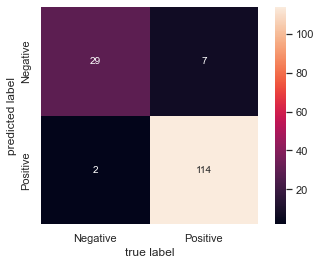


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8881578947368421
Precision: 0.9642857142857143
Recall: 0.8925619834710744
F1 Score: 0.927038626609442
ROC AUC Score: 0.8817648627032793 

              precision    recall  f1-score   support

    Negative       0.68      0.87      0.76        31
    Positive       0.96      0.89      0.93       121

    accuracy                           0.89       152
   macro avg       0.82      0.88      0.84       152
weighted avg       0.91      0.89      0.89       152

Positive Recall: 0.8925619834710744


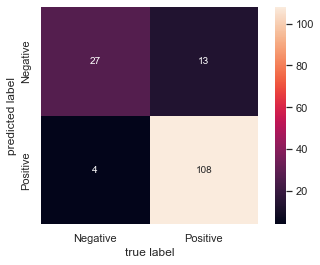


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.9407894736842105
Precision: 0.9745762711864406
Recall: 0.9504132231404959
F1 Score: 0.9623430962343097
ROC AUC Score: 0.9268195147960544 

              precision    recall  f1-score   support

    Negative       0.82      0.90      0.86        31
    Positive       0.97      0.95      0.96       121

    accuracy                           0.94       152
   macro avg       0.90      0.93      0.91       152
weighted avg       0.94      0.94      0.94       152

Positive Recall: 0.9504132231404959


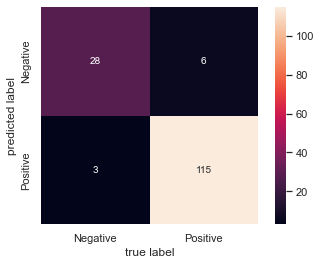


	~~~~	 SVC 	~~~~

Accuracy: 0.9473684210526315
Precision: 0.9669421487603306
Recall: 0.9669421487603306
F1 Score: 0.9669421487603306
ROC AUC Score: 0.9189549453479072 

              precision    recall  f1-score   support

    Negative       0.87      0.87      0.87        31
    Positive       0.97      0.97      0.97       121

    accuracy                           0.95       152
   macro avg       0.92      0.92      0.92       152
weighted avg       0.95      0.95      0.95       152

Positive Recall: 0.9669421487603306


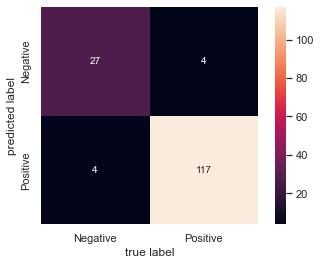


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.9078947368421053
Precision: 0.9495798319327731
Recall: 0.9338842975206612
F1 Score: 0.9416666666666667
ROC AUC Score: 0.8701679552119435 

              precision    recall  f1-score   support

    Negative       0.76      0.81      0.78        31
    Positive       0.95      0.93      0.94       121

    accuracy                           0.91       152
   macro avg       0.85      0.87      0.86       152
weighted avg       0.91      0.91      0.91       152

Positive Recall: 0.9338842975206612


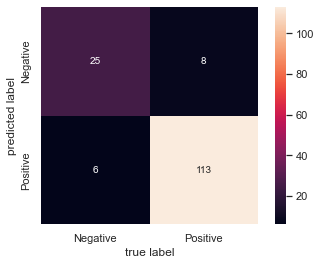




		 *** TOP 200 Features ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.9605263157894737
Precision: 0.9752066115702479
Recall: 0.9752066115702479
F1 Score: 0.9752066115702479
ROC AUC Score: 0.9392162090109303 

              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90        31
    Positive       0.98      0.98      0.98       121

    accuracy                           0.96       152
   macro avg       0.94      0.94      0.94       152
weighted avg       0.96      0.96      0.96       152

Positive Recall: 0.9752066115702479


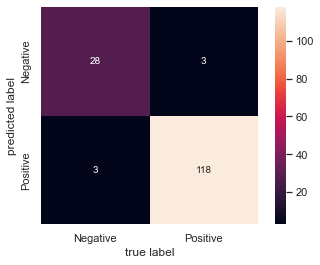


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.9013157894736842
Precision: 0.9491525423728814
Recall: 0.9256198347107438
F1 Score: 0.9372384937238494
ROC AUC Score: 0.8660357238069848 

              precision    recall  f1-score   support

    Negative       0.74      0.81      0.77        31
    Positive       0.95      0.93      0.94       121

    accuracy                           0.90       152
   macro avg       0.84      0.87      0.85       152
weighted avg       0.91      0.90      0.90       152

Positive Recall: 0.9256198347107438


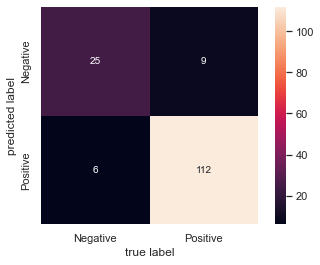


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.9342105263157895
Precision: 0.9663865546218487
Recall: 0.9504132231404959
F1 Score: 0.9583333333333334
ROC AUC Score: 0.91069048253799 

              precision    recall  f1-score   support

    Negative       0.82      0.87      0.84        31
    Positive       0.97      0.95      0.96       121

    accuracy                           0.93       152
   macro avg       0.89      0.91      0.90       152
weighted avg       0.94      0.93      0.93       152

Positive Recall: 0.9504132231404959


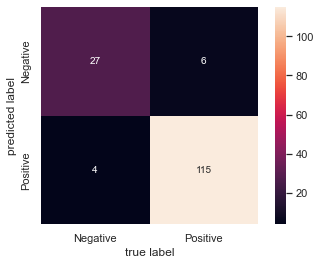


	~~~~	 SVC 	~~~~

Accuracy: 0.9342105263157895
Precision: 0.9512195121951219
Recall: 0.9669421487603306
F1 Score: 0.9590163934426229
ROC AUC Score: 0.8866968808317782 

              precision    recall  f1-score   support

    Negative       0.86      0.81      0.83        31
    Positive       0.95      0.97      0.96       121

    accuracy                           0.93       152
   macro avg       0.91      0.89      0.90       152
weighted avg       0.93      0.93      0.93       152

Positive Recall: 0.9669421487603306


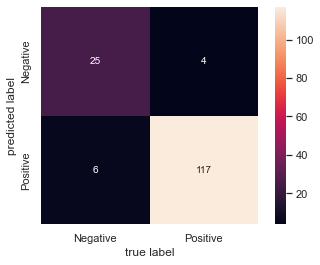


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.881578947368421
Precision: 0.9478260869565217
Recall: 0.9008264462809917
F1 Score: 0.923728813559322
ROC AUC Score: 0.8536390295921087 

              precision    recall  f1-score   support

    Negative       0.68      0.81      0.74        31
    Positive       0.95      0.90      0.92       121

    accuracy                           0.88       152
   macro avg       0.81      0.85      0.83       152
weighted avg       0.89      0.88      0.89       152

Positive Recall: 0.9008264462809917


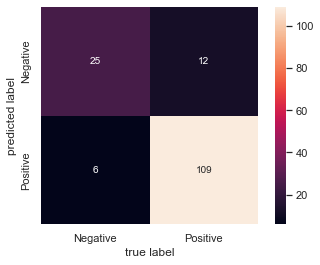




		 *** TOP 250 Features ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.9605263157894737
Precision: 0.9752066115702479
Recall: 0.9752066115702479
F1 Score: 0.9752066115702479
ROC AUC Score: 0.9392162090109303 

              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90        31
    Positive       0.98      0.98      0.98       121

    accuracy                           0.96       152
   macro avg       0.94      0.94      0.94       152
weighted avg       0.96      0.96      0.96       152

Positive Recall: 0.9752066115702479


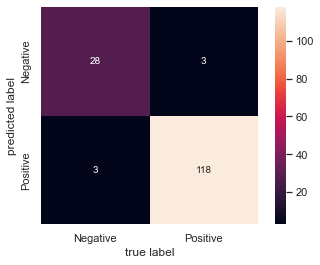


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.9013157894736842
Precision: 0.9491525423728814
Recall: 0.9256198347107438
F1 Score: 0.9372384937238494
ROC AUC Score: 0.8660357238069848 

              precision    recall  f1-score   support

    Negative       0.74      0.81      0.77        31
    Positive       0.95      0.93      0.94       121

    accuracy                           0.90       152
   macro avg       0.84      0.87      0.85       152
weighted avg       0.91      0.90      0.90       152

Positive Recall: 0.9256198347107438


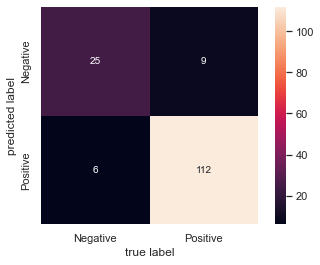


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.9407894736842105
Precision: 0.9590163934426229
Recall: 0.9669421487603306
F1 Score: 0.962962962962963
ROC AUC Score: 0.9028259130898428 

              precision    recall  f1-score   support

    Negative       0.87      0.84      0.85        31
    Positive       0.96      0.97      0.96       121

    accuracy                           0.94       152
   macro avg       0.91      0.90      0.91       152
weighted avg       0.94      0.94      0.94       152

Positive Recall: 0.9669421487603306


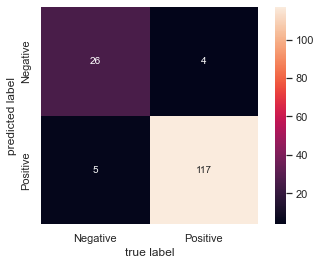


	~~~~	 SVC 	~~~~

Accuracy: 0.9473684210526315
Precision: 0.959349593495935
Recall: 0.9752066115702479
F1 Score: 0.9672131147540983
ROC AUC Score: 0.9069581444948014 

              precision    recall  f1-score   support

    Negative       0.90      0.84      0.87        31
    Positive       0.96      0.98      0.97       121

    accuracy                           0.95       152
   macro avg       0.93      0.91      0.92       152
weighted avg       0.95      0.95      0.95       152

Positive Recall: 0.9752066115702479


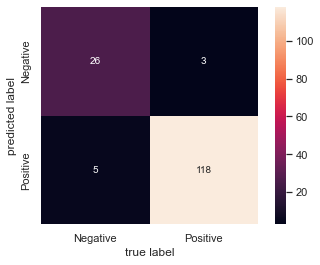


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.881578947368421
Precision: 0.9557522123893806
Recall: 0.8925619834710744
F1 Score: 0.923076923076923
ROC AUC Score: 0.8656358304452147 

              precision    recall  f1-score   support

    Negative       0.67      0.84      0.74        31
    Positive       0.96      0.89      0.92       121

    accuracy                           0.88       152
   macro avg       0.81      0.87      0.83       152
weighted avg       0.90      0.88      0.89       152

Positive Recall: 0.8925619834710744


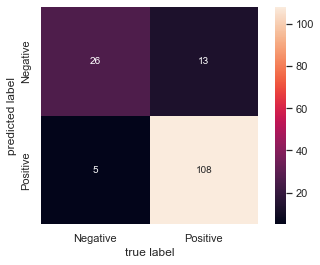




		 *** TOP 300 Features ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.9671052631578947
Precision: 0.9754098360655737
Recall: 0.9834710743801653
F1 Score: 0.9794238683127573
ROC AUC Score: 0.9433484404158892 

              precision    recall  f1-score   support

    Negative       0.93      0.90      0.92        31
    Positive       0.98      0.98      0.98       121

    accuracy                           0.97       152
   macro avg       0.95      0.94      0.95       152
weighted avg       0.97      0.97      0.97       152

Positive Recall: 0.9834710743801653


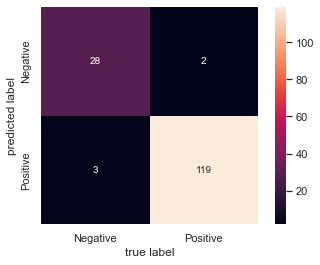


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.881578947368421
Precision: 0.9478260869565217
Recall: 0.9008264462809917
F1 Score: 0.923728813559322
ROC AUC Score: 0.8536390295921087 

              precision    recall  f1-score   support

    Negative       0.68      0.81      0.74        31
    Positive       0.95      0.90      0.92       121

    accuracy                           0.88       152
   macro avg       0.81      0.85      0.83       152
weighted avg       0.89      0.88      0.89       152

Positive Recall: 0.9008264462809917


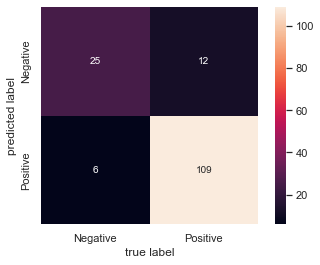


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.9473684210526315
Precision: 0.9669421487603306
Recall: 0.9669421487603306
F1 Score: 0.9669421487603306
ROC AUC Score: 0.9189549453479072 

              precision    recall  f1-score   support

    Negative       0.87      0.87      0.87        31
    Positive       0.97      0.97      0.97       121

    accuracy                           0.95       152
   macro avg       0.92      0.92      0.92       152
weighted avg       0.95      0.95      0.95       152

Positive Recall: 0.9669421487603306


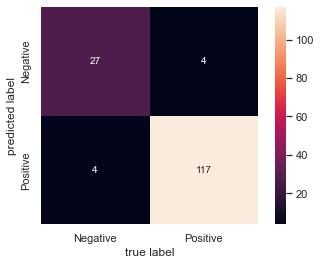


	~~~~	 SVC 	~~~~

Accuracy: 0.9276315789473685
Precision: 0.9296875
Recall: 0.9834710743801653
F1 Score: 0.9558232931726908
ROC AUC Score: 0.846574246867502 

              precision    recall  f1-score   support

    Negative       0.92      0.71      0.80        31
    Positive       0.93      0.98      0.96       121

    accuracy                           0.93       152
   macro avg       0.92      0.85      0.88       152
weighted avg       0.93      0.93      0.92       152

Positive Recall: 0.9834710743801653


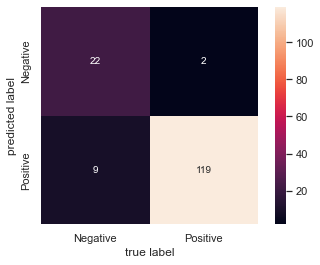


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.9013157894736842
Precision: 0.9568965517241379
Recall: 0.9173553719008265
F1 Score: 0.9367088607594937
ROC AUC Score: 0.8780325246600907 

              precision    recall  f1-score   support

    Negative       0.72      0.84      0.78        31
    Positive       0.96      0.92      0.94       121

    accuracy                           0.90       152
   macro avg       0.84      0.88      0.86       152
weighted avg       0.91      0.90      0.90       152

Positive Recall: 0.9173553719008265


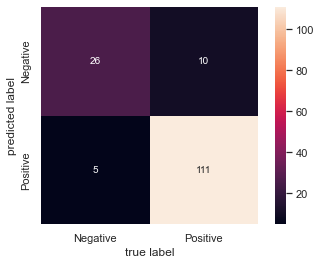




		 *** TOP 350 Features ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.9605263157894737
Precision: 0.9752066115702479
Recall: 0.9752066115702479
F1 Score: 0.9752066115702479
ROC AUC Score: 0.9392162090109303 

              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90        31
    Positive       0.98      0.98      0.98       121

    accuracy                           0.96       152
   macro avg       0.94      0.94      0.94       152
weighted avg       0.96      0.96      0.96       152

Positive Recall: 0.9752066115702479


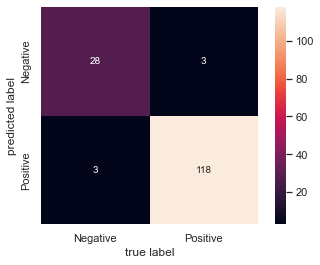


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8947368421052632
Precision: 0.9565217391304348
Recall: 0.9090909090909091
F1 Score: 0.9322033898305085
ROC AUC Score: 0.8739002932551321 

              precision    recall  f1-score   support

    Negative       0.70      0.84      0.76        31
    Positive       0.96      0.91      0.93       121

    accuracy                           0.89       152
   macro avg       0.83      0.87      0.85       152
weighted avg       0.90      0.89      0.90       152

Positive Recall: 0.9090909090909091


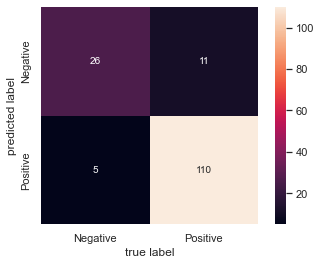


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.9605263157894737
Precision: 0.9752066115702479
Recall: 0.9752066115702479
F1 Score: 0.9752066115702479
ROC AUC Score: 0.9392162090109303 

              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90        31
    Positive       0.98      0.98      0.98       121

    accuracy                           0.96       152
   macro avg       0.94      0.94      0.94       152
weighted avg       0.96      0.96      0.96       152

Positive Recall: 0.9752066115702479


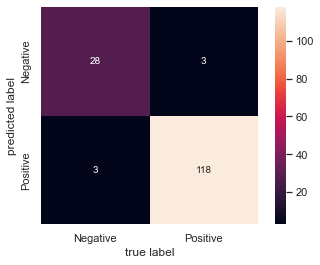


	~~~~	 SVC 	~~~~

Accuracy: 0.9276315789473685
Precision: 0.9296875
Recall: 0.9834710743801653
F1 Score: 0.9558232931726908
ROC AUC Score: 0.846574246867502 

              precision    recall  f1-score   support

    Negative       0.92      0.71      0.80        31
    Positive       0.93      0.98      0.96       121

    accuracy                           0.93       152
   macro avg       0.92      0.85      0.88       152
weighted avg       0.93      0.93      0.92       152

Positive Recall: 0.9834710743801653


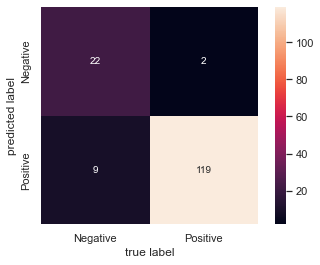


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.8289473684210527
Precision: 0.9439252336448598
Recall: 0.8347107438016529
F1 Score: 0.8859649122807018
ROC AUC Score: 0.8205811783524394 

              precision    recall  f1-score   support

    Negative       0.56      0.81      0.66        31
    Positive       0.94      0.83      0.89       121

    accuracy                           0.83       152
   macro avg       0.75      0.82      0.77       152
weighted avg       0.86      0.83      0.84       152

Positive Recall: 0.8347107438016529


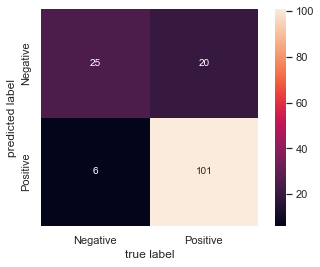




		 *** TOP 400 Features ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.9407894736842105
Precision: 0.9827586206896551
Recall: 0.9421487603305785
F1 Score: 0.9620253164556961
ROC AUC Score: 0.9388163156491602 

              precision    recall  f1-score   support

    Negative       0.81      0.94      0.87        31
    Positive       0.98      0.94      0.96       121

    accuracy                           0.94       152
   macro avg       0.89      0.94      0.91       152
weighted avg       0.95      0.94      0.94       152

Positive Recall: 0.9421487603305785


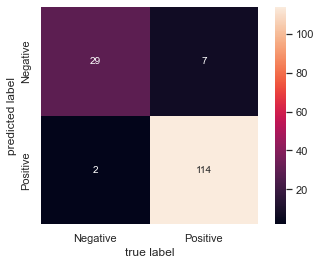


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.9144736842105263
Precision: 0.9736842105263158
Recall: 0.9173553719008265
F1 Score: 0.9446808510638298
ROC AUC Score: 0.9102905891762197 

              precision    recall  f1-score   support

    Negative       0.74      0.90      0.81        31
    Positive       0.97      0.92      0.94       121

    accuracy                           0.91       152
   macro avg       0.86      0.91      0.88       152
weighted avg       0.93      0.91      0.92       152

Positive Recall: 0.9173553719008265


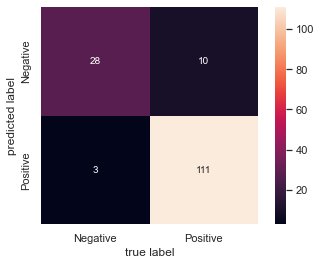


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.9342105263157895
Precision: 0.9663865546218487
Recall: 0.9504132231404959
F1 Score: 0.9583333333333334
ROC AUC Score: 0.91069048253799 

              precision    recall  f1-score   support

    Negative       0.82      0.87      0.84        31
    Positive       0.97      0.95      0.96       121

    accuracy                           0.93       152
   macro avg       0.89      0.91      0.90       152
weighted avg       0.94      0.93      0.93       152

Positive Recall: 0.9504132231404959


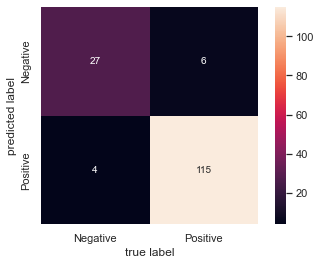


	~~~~	 SVC 	~~~~

Accuracy: 0.9210526315789473
Precision: 0.9291338582677166
Recall: 0.9752066115702479
F1 Score: 0.9516129032258065
ROC AUC Score: 0.8424420154625433 

              precision    recall  f1-score   support

    Negative       0.88      0.71      0.79        31
    Positive       0.93      0.98      0.95       121

    accuracy                           0.92       152
   macro avg       0.90      0.84      0.87       152
weighted avg       0.92      0.92      0.92       152

Positive Recall: 0.9752066115702479


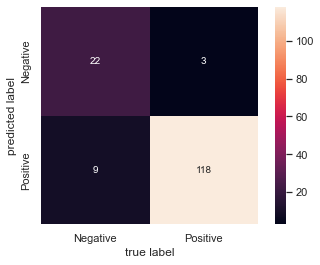


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.7960526315789473
Precision: 0.9326923076923077
Recall: 0.8016528925619835
F1 Score: 0.8622222222222222
ROC AUC Score: 0.7879232204745401 

              precision    recall  f1-score   support

    Negative       0.50      0.77      0.61        31
    Positive       0.93      0.80      0.86       121

    accuracy                           0.80       152
   macro avg       0.72      0.79      0.73       152
weighted avg       0.84      0.80      0.81       152

Positive Recall: 0.8016528925619835


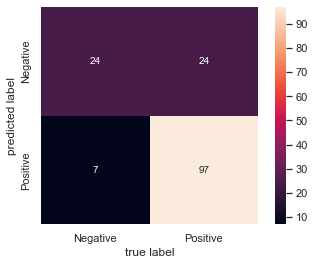




		 *** TOP 450 Features ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.9407894736842105
Precision: 0.9666666666666667
Recall: 0.9586776859504132
F1 Score: 0.9626556016597511
ROC AUC Score: 0.9148227139429485 

              precision    recall  f1-score   support

    Negative       0.84      0.87      0.86        31
    Positive       0.97      0.96      0.96       121

    accuracy                           0.94       152
   macro avg       0.91      0.91      0.91       152
weighted avg       0.94      0.94      0.94       152

Positive Recall: 0.9586776859504132


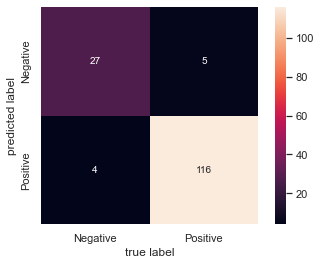


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8881578947368421
Precision: 0.956140350877193
Recall: 0.9008264462809917
F1 Score: 0.927659574468085
ROC AUC Score: 0.8697680618501732 

              precision    recall  f1-score   support

    Negative       0.68      0.84      0.75        31
    Positive       0.96      0.90      0.93       121

    accuracy                           0.89       152
   macro avg       0.82      0.87      0.84       152
weighted avg       0.90      0.89      0.89       152

Positive Recall: 0.9008264462809917


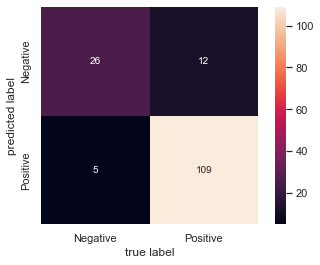


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.9539473684210527
Precision: 0.975
Recall: 0.9669421487603306
F1 Score: 0.970954356846473
ROC AUC Score: 0.9350839776059717 

              precision    recall  f1-score   support

    Negative       0.88      0.90      0.89        31
    Positive       0.97      0.97      0.97       121

    accuracy                           0.95       152
   macro avg       0.93      0.94      0.93       152
weighted avg       0.95      0.95      0.95       152

Positive Recall: 0.9669421487603306


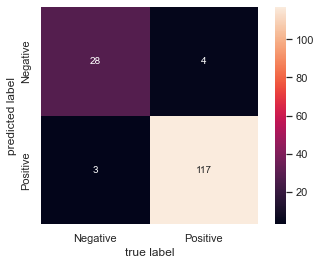


	~~~~	 SVC 	~~~~

Accuracy: 0.9210526315789473
Precision: 0.9224806201550387
Recall: 0.9834710743801653
F1 Score: 0.9520000000000001
ROC AUC Score: 0.8304452146094375 

              precision    recall  f1-score   support

    Negative       0.91      0.68      0.78        31
    Positive       0.92      0.98      0.95       121

    accuracy                           0.92       152
   macro avg       0.92      0.83      0.86       152
weighted avg       0.92      0.92      0.92       152

Positive Recall: 0.9834710743801653


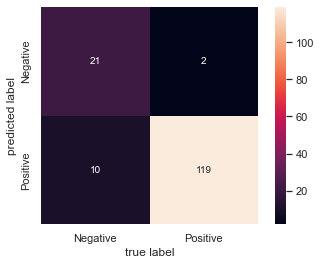


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.8223684210526315
Precision: 0.9519230769230769
Recall: 0.8181818181818182
F1 Score: 0.8800000000000001
ROC AUC Score: 0.8284457478005867 

              precision    recall  f1-score   support

    Negative       0.54      0.84      0.66        31
    Positive       0.95      0.82      0.88       121

    accuracy                           0.82       152
   macro avg       0.75      0.83      0.77       152
weighted avg       0.87      0.82      0.83       152

Positive Recall: 0.8181818181818182


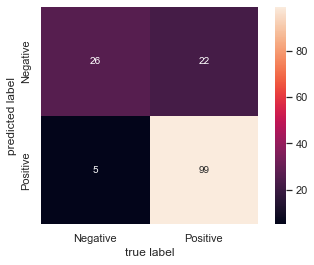




		 *** TOP 500 Features ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.9605263157894737
Precision: 0.967479674796748
Recall: 0.9834710743801653
F1 Score: 0.9754098360655739
ROC AUC Score: 0.9272194081578247 

              precision    recall  f1-score   support

    Negative       0.93      0.87      0.90        31
    Positive       0.97      0.98      0.98       121

    accuracy                           0.96       152
   macro avg       0.95      0.93      0.94       152
weighted avg       0.96      0.96      0.96       152

Positive Recall: 0.9834710743801653


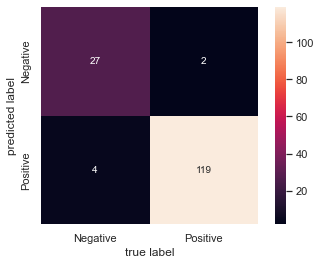


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.9013157894736842
Precision: 0.9732142857142857
Recall: 0.9008264462809917
F1 Score: 0.9356223175965664
ROC AUC Score: 0.9020261263663022 

              precision    recall  f1-score   support

    Negative       0.70      0.90      0.79        31
    Positive       0.97      0.90      0.94       121

    accuracy                           0.90       152
   macro avg       0.84      0.90      0.86       152
weighted avg       0.92      0.90      0.91       152

Positive Recall: 0.9008264462809917


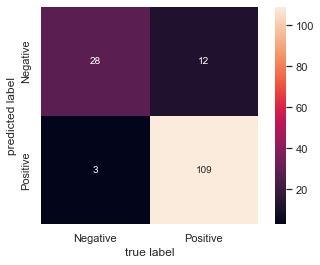


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.9539473684210527
Precision: 0.975
Recall: 0.9669421487603306
F1 Score: 0.970954356846473
ROC AUC Score: 0.9350839776059717 

              precision    recall  f1-score   support

    Negative       0.88      0.90      0.89        31
    Positive       0.97      0.97      0.97       121

    accuracy                           0.95       152
   macro avg       0.93      0.94      0.93       152
weighted avg       0.95      0.95      0.95       152

Positive Recall: 0.9669421487603306


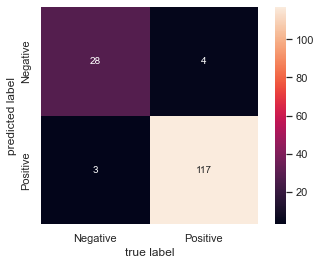


	~~~~	 SVC 	~~~~

Accuracy: 0.9210526315789473
Precision: 0.9224806201550387
Recall: 0.9834710743801653
F1 Score: 0.9520000000000001
ROC AUC Score: 0.8304452146094375 

              precision    recall  f1-score   support

    Negative       0.91      0.68      0.78        31
    Positive       0.92      0.98      0.95       121

    accuracy                           0.92       152
   macro avg       0.92      0.83      0.86       152
weighted avg       0.92      0.92      0.92       152

Positive Recall: 0.9834710743801653


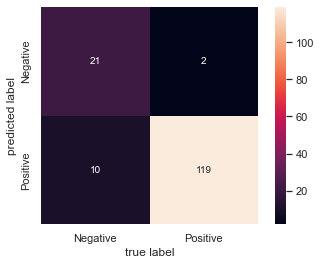


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.8157894736842105
Precision: 0.9428571428571428
Recall: 0.8181818181818182
F1 Score: 0.8761061946902655
ROC AUC Score: 0.812316715542522 

              precision    recall  f1-score   support

    Negative       0.53      0.81      0.64        31
    Positive       0.94      0.82      0.88       121

    accuracy                           0.82       152
   macro avg       0.74      0.81      0.76       152
weighted avg       0.86      0.82      0.83       152

Positive Recall: 0.8181818181818182


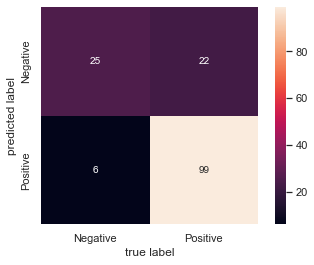




		 *** TOP 550 Features ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.9342105263157895
Precision: 0.9586776859504132
Recall: 0.9586776859504132
F1 Score: 0.9586776859504132
ROC AUC Score: 0.898693681684884 

              precision    recall  f1-score   support

    Negative       0.84      0.84      0.84        31
    Positive       0.96      0.96      0.96       121

    accuracy                           0.93       152
   macro avg       0.90      0.90      0.90       152
weighted avg       0.93      0.93      0.93       152

Positive Recall: 0.9586776859504132


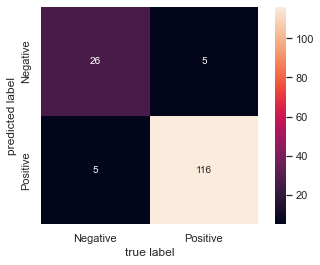


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.9013157894736842
Precision: 0.9649122807017544
Recall: 0.9090909090909091
F1 Score: 0.9361702127659574
ROC AUC Score: 0.8900293255131965 

              precision    recall  f1-score   support

    Negative       0.71      0.87      0.78        31
    Positive       0.96      0.91      0.94       121

    accuracy                           0.90       152
   macro avg       0.84      0.89      0.86       152
weighted avg       0.91      0.90      0.90       152

Positive Recall: 0.9090909090909091


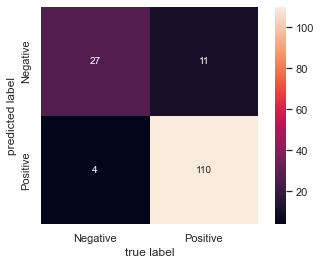


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.9605263157894737
Precision: 0.9831932773109243
Recall: 0.9669421487603306
F1 Score: 0.975
ROC AUC Score: 0.9512130098640365 

              precision    recall  f1-score   support

    Negative       0.88      0.94      0.91        31
    Positive       0.98      0.97      0.97       121

    accuracy                           0.96       152
   macro avg       0.93      0.95      0.94       152
weighted avg       0.96      0.96      0.96       152

Positive Recall: 0.9669421487603306


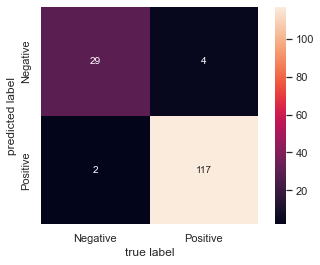


	~~~~	 SVC 	~~~~

Accuracy: 0.9078947368421053
Precision: 0.9083969465648855
Recall: 0.9834710743801653
F1 Score: 0.9444444444444445
ROC AUC Score: 0.7981871500933085 

              precision    recall  f1-score   support

    Negative       0.90      0.61      0.73        31
    Positive       0.91      0.98      0.94       121

    accuracy                           0.91       152
   macro avg       0.91      0.80      0.84       152
weighted avg       0.91      0.91      0.90       152

Positive Recall: 0.9834710743801653


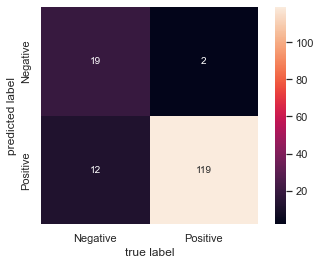


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.8223684210526315
Precision: 0.9433962264150944
Recall: 0.8264462809917356
F1 Score: 0.8810572687224669
ROC AUC Score: 0.8164489469474806 

              precision    recall  f1-score   support

    Negative       0.54      0.81      0.65        31
    Positive       0.94      0.83      0.88       121

    accuracy                           0.82       152
   macro avg       0.74      0.82      0.77       152
weighted avg       0.86      0.82      0.83       152

Positive Recall: 0.8264462809917356


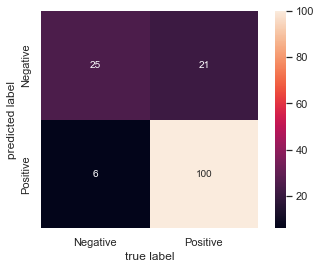




		 *** TOP 600 Features ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.9342105263157895
Precision: 0.9586776859504132
Recall: 0.9586776859504132
F1 Score: 0.9586776859504132
ROC AUC Score: 0.898693681684884 

              precision    recall  f1-score   support

    Negative       0.84      0.84      0.84        31
    Positive       0.96      0.96      0.96       121

    accuracy                           0.93       152
   macro avg       0.90      0.90      0.90       152
weighted avg       0.93      0.93      0.93       152

Positive Recall: 0.9586776859504132


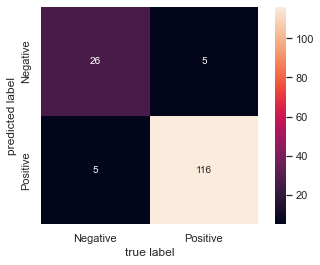


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8486842105263158
Precision: 0.9537037037037037
Recall: 0.8512396694214877
F1 Score: 0.8995633187772927
ROC AUC Score: 0.8449746734204213 

              precision    recall  f1-score   support

    Negative       0.59      0.84      0.69        31
    Positive       0.95      0.85      0.90       121

    accuracy                           0.85       152
   macro avg       0.77      0.84      0.80       152
weighted avg       0.88      0.85      0.86       152

Positive Recall: 0.8512396694214877


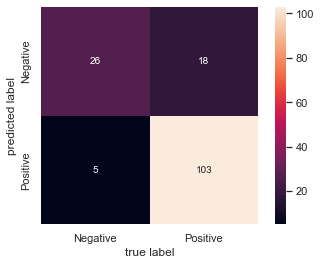


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.9605263157894737
Precision: 0.9831932773109243
Recall: 0.9669421487603306
F1 Score: 0.975
ROC AUC Score: 0.9512130098640365 

              precision    recall  f1-score   support

    Negative       0.88      0.94      0.91        31
    Positive       0.98      0.97      0.97       121

    accuracy                           0.96       152
   macro avg       0.93      0.95      0.94       152
weighted avg       0.96      0.96      0.96       152

Positive Recall: 0.9669421487603306


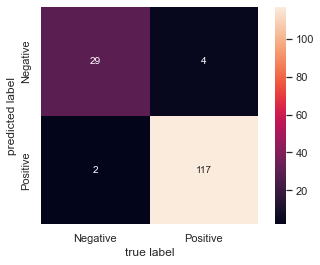


	~~~~	 SVC 	~~~~

Accuracy: 0.9078947368421053
Precision: 0.9083969465648855
Recall: 0.9834710743801653
F1 Score: 0.9444444444444445
ROC AUC Score: 0.7981871500933085 

              precision    recall  f1-score   support

    Negative       0.90      0.61      0.73        31
    Positive       0.91      0.98      0.94       121

    accuracy                           0.91       152
   macro avg       0.91      0.80      0.84       152
weighted avg       0.91      0.91      0.90       152

Positive Recall: 0.9834710743801653


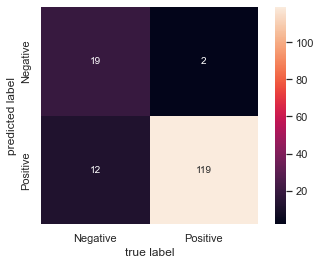


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.8157894736842105
Precision: 0.9345794392523364
Recall: 0.8264462809917356
F1 Score: 0.8771929824561404
ROC AUC Score: 0.8003199146894161 

              precision    recall  f1-score   support

    Negative       0.53      0.77      0.63        31
    Positive       0.93      0.83      0.88       121

    accuracy                           0.82       152
   macro avg       0.73      0.80      0.75       152
weighted avg       0.85      0.82      0.83       152

Positive Recall: 0.8264462809917356


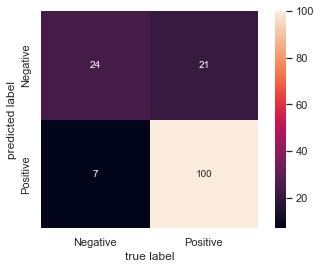




		 *** TOP 650 Features ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.9671052631578947
Precision: 0.9754098360655737
Recall: 0.9834710743801653
F1 Score: 0.9794238683127573
ROC AUC Score: 0.9433484404158892 

              precision    recall  f1-score   support

    Negative       0.93      0.90      0.92        31
    Positive       0.98      0.98      0.98       121

    accuracy                           0.97       152
   macro avg       0.95      0.94      0.95       152
weighted avg       0.97      0.97      0.97       152

Positive Recall: 0.9834710743801653


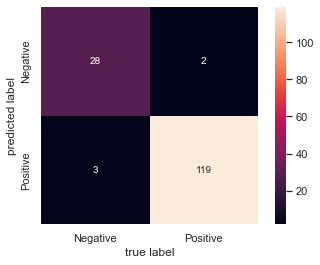


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8881578947368421
Precision: 0.9642857142857143
Recall: 0.8925619834710744
F1 Score: 0.927038626609442
ROC AUC Score: 0.8817648627032793 

              precision    recall  f1-score   support

    Negative       0.68      0.87      0.76        31
    Positive       0.96      0.89      0.93       121

    accuracy                           0.89       152
   macro avg       0.82      0.88      0.84       152
weighted avg       0.91      0.89      0.89       152

Positive Recall: 0.8925619834710744


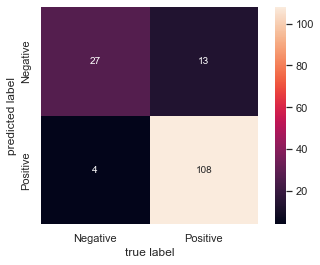


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.9539473684210527
Precision: 0.9830508474576272
Recall: 0.9586776859504132
F1 Score: 0.9707112970711298
ROC AUC Score: 0.9470807784590777 

              precision    recall  f1-score   support

    Negative       0.85      0.94      0.89        31
    Positive       0.98      0.96      0.97       121

    accuracy                           0.95       152
   macro avg       0.92      0.95      0.93       152
weighted avg       0.96      0.95      0.95       152

Positive Recall: 0.9586776859504132


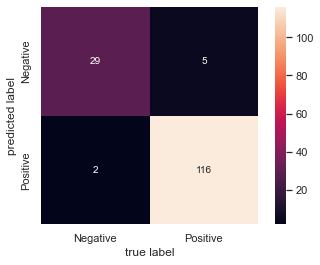


	~~~~	 SVC 	~~~~

Accuracy: 0.9078947368421053
Precision: 0.9083969465648855
Recall: 0.9834710743801653
F1 Score: 0.9444444444444445
ROC AUC Score: 0.7981871500933085 

              precision    recall  f1-score   support

    Negative       0.90      0.61      0.73        31
    Positive       0.91      0.98      0.94       121

    accuracy                           0.91       152
   macro avg       0.91      0.80      0.84       152
weighted avg       0.91      0.91      0.90       152

Positive Recall: 0.9834710743801653


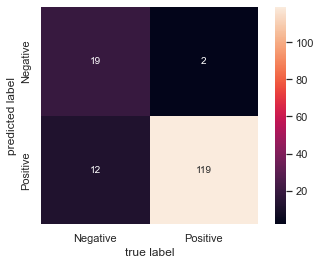


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.7894736842105263
Precision: 0.9320388349514563
Recall: 0.7933884297520661
F1 Score: 0.8571428571428571
ROC AUC Score: 0.7837909890695814 

              precision    recall  f1-score   support

    Negative       0.49      0.77      0.60        31
    Positive       0.93      0.79      0.86       121

    accuracy                           0.79       152
   macro avg       0.71      0.78      0.73       152
weighted avg       0.84      0.79      0.80       152

Positive Recall: 0.7933884297520661


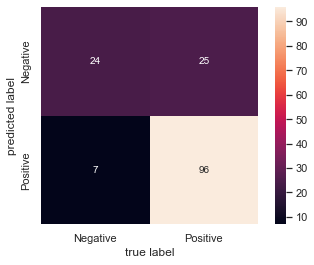




		 *** TOP 700 Features ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.9407894736842105
Precision: 0.9516129032258065
Recall: 0.9752066115702479
F1 Score: 0.963265306122449
ROC AUC Score: 0.8908291122367367 

              precision    recall  f1-score   support

    Negative       0.89      0.81      0.85        31
    Positive       0.95      0.98      0.96       121

    accuracy                           0.94       152
   macro avg       0.92      0.89      0.91       152
weighted avg       0.94      0.94      0.94       152

Positive Recall: 0.9752066115702479


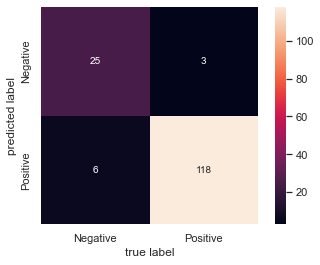


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.868421052631579
Precision: 0.963302752293578
Recall: 0.8677685950413223
F1 Score: 0.9130434782608695
ROC AUC Score: 0.869368168488403 

              precision    recall  f1-score   support

    Negative       0.63      0.87      0.73        31
    Positive       0.96      0.87      0.91       121

    accuracy                           0.87       152
   macro avg       0.80      0.87      0.82       152
weighted avg       0.89      0.87      0.88       152

Positive Recall: 0.8677685950413223


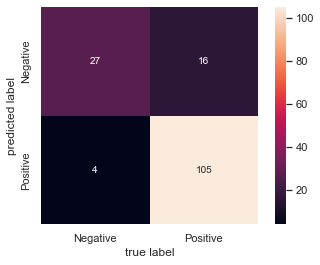


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.9407894736842105
Precision: 0.9827586206896551
Recall: 0.9421487603305785
F1 Score: 0.9620253164556961
ROC AUC Score: 0.9388163156491602 

              precision    recall  f1-score   support

    Negative       0.81      0.94      0.87        31
    Positive       0.98      0.94      0.96       121

    accuracy                           0.94       152
   macro avg       0.89      0.94      0.91       152
weighted avg       0.95      0.94      0.94       152

Positive Recall: 0.9421487603305785


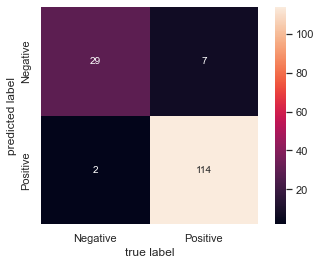


	~~~~	 SVC 	~~~~

Accuracy: 0.9078947368421053
Precision: 0.9083969465648855
Recall: 0.9834710743801653
F1 Score: 0.9444444444444445
ROC AUC Score: 0.7981871500933085 

              precision    recall  f1-score   support

    Negative       0.90      0.61      0.73        31
    Positive       0.91      0.98      0.94       121

    accuracy                           0.91       152
   macro avg       0.91      0.80      0.84       152
weighted avg       0.91      0.91      0.90       152

Positive Recall: 0.9834710743801653


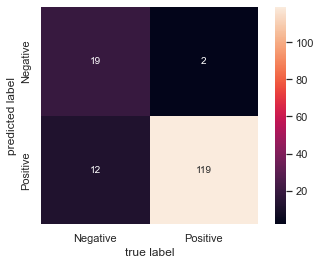


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.7697368421052632
Precision: 0.93
Recall: 0.768595041322314
F1 Score: 0.8416289592760182
ROC AUC Score: 0.7713942948547053 

              precision    recall  f1-score   support

    Negative       0.46      0.77      0.58        31
    Positive       0.93      0.77      0.84       121

    accuracy                           0.77       152
   macro avg       0.70      0.77      0.71       152
weighted avg       0.83      0.77      0.79       152

Positive Recall: 0.768595041322314


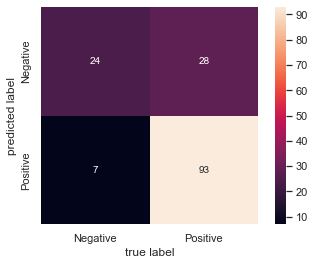




		 *** TOP 750 Features ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.9276315789473685
Precision: 0.9435483870967742
Recall: 0.9669421487603306
F1 Score: 0.9551020408163265
ROC AUC Score: 0.8705678485737137 

              precision    recall  f1-score   support

    Negative       0.86      0.77      0.81        31
    Positive       0.94      0.97      0.96       121

    accuracy                           0.93       152
   macro avg       0.90      0.87      0.88       152
weighted avg       0.93      0.93      0.93       152

Positive Recall: 0.9669421487603306


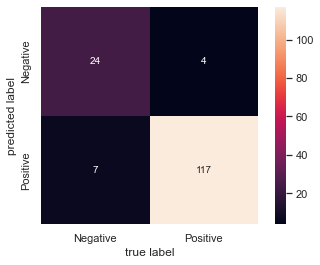


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8552631578947368
Precision: 0.9541284403669725
Recall: 0.859504132231405
F1 Score: 0.9043478260869566
ROC AUC Score: 0.84910690482538 

              precision    recall  f1-score   support

    Negative       0.60      0.84      0.70        31
    Positive       0.95      0.86      0.90       121

    accuracy                           0.86       152
   macro avg       0.78      0.85      0.80       152
weighted avg       0.88      0.86      0.86       152

Positive Recall: 0.859504132231405


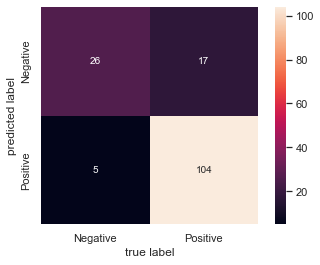


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.9473684210526315
Precision: 0.9669421487603306
Recall: 0.9669421487603306
F1 Score: 0.9669421487603306
ROC AUC Score: 0.9189549453479072 

              precision    recall  f1-score   support

    Negative       0.87      0.87      0.87        31
    Positive       0.97      0.97      0.97       121

    accuracy                           0.95       152
   macro avg       0.92      0.92      0.92       152
weighted avg       0.95      0.95      0.95       152

Positive Recall: 0.9669421487603306


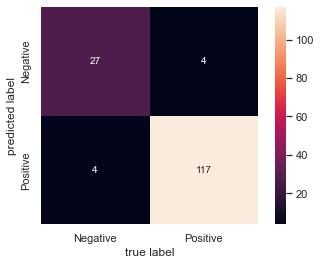


	~~~~	 SVC 	~~~~

Accuracy: 0.9078947368421053
Precision: 0.9083969465648855
Recall: 0.9834710743801653
F1 Score: 0.9444444444444445
ROC AUC Score: 0.7981871500933085 

              precision    recall  f1-score   support

    Negative       0.90      0.61      0.73        31
    Positive       0.91      0.98      0.94       121

    accuracy                           0.91       152
   macro avg       0.91      0.80      0.84       152
weighted avg       0.91      0.91      0.90       152

Positive Recall: 0.9834710743801653


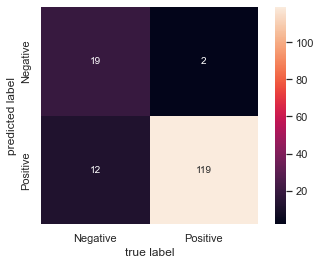


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.756578947368421
Precision: 0.9285714285714286
Recall: 0.7520661157024794
F1 Score: 0.8310502283105023
ROC AUC Score: 0.763129832044788 

              precision    recall  f1-score   support

    Negative       0.44      0.77      0.56        31
    Positive       0.93      0.75      0.83       121

    accuracy                           0.76       152
   macro avg       0.69      0.76      0.70       152
weighted avg       0.83      0.76      0.78       152

Positive Recall: 0.7520661157024794


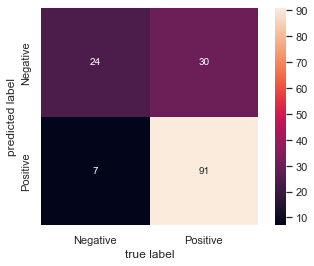




		 *** PCA 50 Components ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.875
Precision: 0.8695652173913043
Recall: 0.9917355371900827
F1 Score: 0.9266409266409266
ROC AUC Score: 0.70554518794988 

              precision    recall  f1-score   support

    Negative       0.93      0.42      0.58        31
    Positive       0.87      0.99      0.93       121

    accuracy                           0.88       152
   macro avg       0.90      0.71      0.75       152
weighted avg       0.88      0.88      0.86       152

Positive Recall: 0.9917355371900827


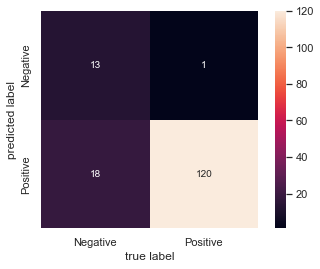


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8421052631578947
Precision: 0.888
Recall: 0.9173553719008265
F1 Score: 0.9024390243902439
ROC AUC Score: 0.73287123433751 

              precision    recall  f1-score   support

    Negative       0.63      0.55      0.59        31
    Positive       0.89      0.92      0.90       121

    accuracy                           0.84       152
   macro avg       0.76      0.73      0.74       152
weighted avg       0.84      0.84      0.84       152

Positive Recall: 0.9173553719008265


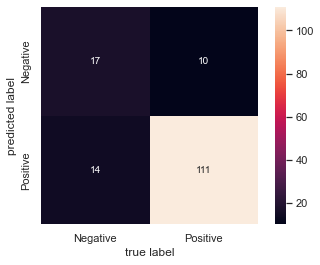


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.8618421052631579
Precision: 0.8787878787878788
Recall: 0.9586776859504132
F1 Score: 0.91699604743083
ROC AUC Score: 0.7212743268461743 

              precision    recall  f1-score   support

    Negative       0.75      0.48      0.59        31
    Positive       0.88      0.96      0.92       121

    accuracy                           0.86       152
   macro avg       0.81      0.72      0.75       152
weighted avg       0.85      0.86      0.85       152

Positive Recall: 0.9586776859504132


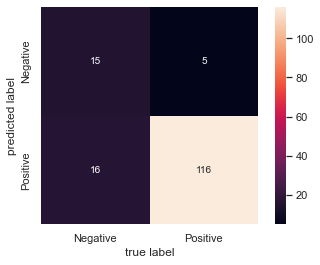


	~~~~	 SVC 	~~~~

Accuracy: 0.8881578947368421
Precision: 0.8823529411764706
Recall: 0.9917355371900827
F1 Score: 0.933852140077821
ROC AUC Score: 0.7378032524660091 

              precision    recall  f1-score   support

    Negative       0.94      0.48      0.64        31
    Positive       0.88      0.99      0.93       121

    accuracy                           0.89       152
   macro avg       0.91      0.74      0.79       152
weighted avg       0.89      0.89      0.87       152

Positive Recall: 0.9917355371900827


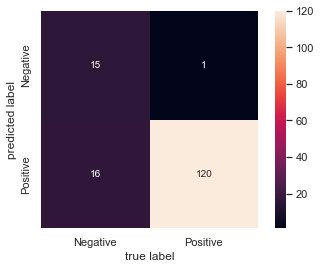


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.8552631578947368
Precision: 0.8721804511278195
Recall: 0.9586776859504132
F1 Score: 0.9133858267716535
ROC AUC Score: 0.7051452945881098 

              precision    recall  f1-score   support

    Negative       0.74      0.45      0.56        31
    Positive       0.87      0.96      0.91       121

    accuracy                           0.86       152
   macro avg       0.80      0.71      0.74       152
weighted avg       0.84      0.86      0.84       152

Positive Recall: 0.9586776859504132


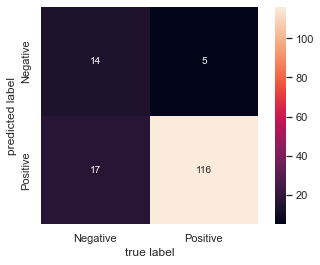




		 *** PCA 100 Components ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.8881578947368421
Precision: 0.8768115942028986
Recall: 1.0
F1 Score: 0.9343629343629344
ROC AUC Score: 0.7258064516129032 

              precision    recall  f1-score   support

    Negative       1.00      0.45      0.62        31
    Positive       0.88      1.00      0.93       121

    accuracy                           0.89       152
   macro avg       0.94      0.73      0.78       152
weighted avg       0.90      0.89      0.87       152

Positive Recall: 1.0


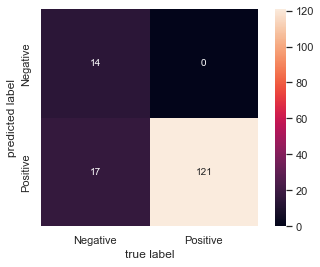


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8289473684210527
Precision: 0.88
Recall: 0.9090909090909091
F1 Score: 0.8943089430894309
ROC AUC Score: 0.7126099706744868 

              precision    recall  f1-score   support

    Negative       0.59      0.52      0.55        31
    Positive       0.88      0.91      0.89       121

    accuracy                           0.83       152
   macro avg       0.74      0.71      0.72       152
weighted avg       0.82      0.83      0.82       152

Positive Recall: 0.9090909090909091


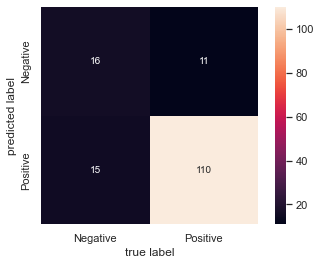


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.875
Precision: 0.8863636363636364
Recall: 0.9669421487603306
F1 Score: 0.924901185770751
ROC AUC Score: 0.7415355905091976 

              precision    recall  f1-score   support

    Negative       0.80      0.52      0.63        31
    Positive       0.89      0.97      0.92       121

    accuracy                           0.88       152
   macro avg       0.84      0.74      0.78       152
weighted avg       0.87      0.88      0.86       152

Positive Recall: 0.9669421487603306


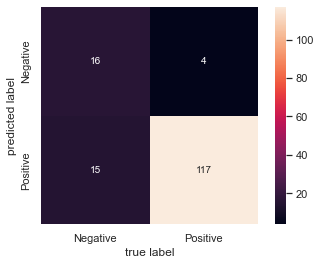


	~~~~	 SVC 	~~~~

Accuracy: 0.8947368421052632
Precision: 0.8888888888888888
Recall: 0.9917355371900827
F1 Score: 0.9375
ROC AUC Score: 0.7539322847240736 

              precision    recall  f1-score   support

    Negative       0.94      0.52      0.67        31
    Positive       0.89      0.99      0.94       121

    accuracy                           0.89       152
   macro avg       0.92      0.75      0.80       152
weighted avg       0.90      0.89      0.88       152

Positive Recall: 0.9917355371900827


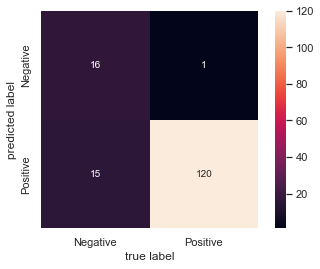


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.8552631578947368
Precision: 0.896
Recall: 0.9256198347107438
F1 Score: 0.9105691056910571
ROC AUC Score: 0.7531324980005332 

              precision    recall  f1-score   support

    Negative       0.67      0.58      0.62        31
    Positive       0.90      0.93      0.91       121

    accuracy                           0.86       152
   macro avg       0.78      0.75      0.77       152
weighted avg       0.85      0.86      0.85       152

Positive Recall: 0.9256198347107438


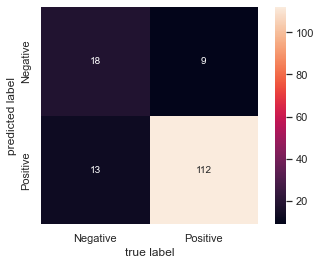




		 *** PCA 150 Components ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.8618421052631579
Precision: 0.852112676056338
Recall: 1.0
F1 Score: 0.9201520912547528
ROC AUC Score: 0.6612903225806452 

              precision    recall  f1-score   support

    Negative       1.00      0.32      0.49        31
    Positive       0.85      1.00      0.92       121

    accuracy                           0.86       152
   macro avg       0.93      0.66      0.70       152
weighted avg       0.88      0.86      0.83       152

Positive Recall: 1.0


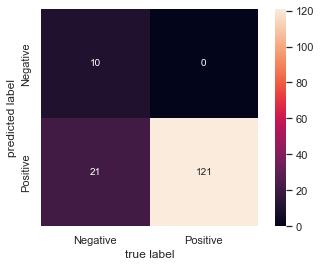


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8618421052631579
Precision: 0.9310344827586207
Recall: 0.8925619834710744
F1 Score: 0.9113924050632911
ROC AUC Score: 0.8172487336710211 

              precision    recall  f1-score   support

    Negative       0.64      0.74      0.69        31
    Positive       0.93      0.89      0.91       121

    accuracy                           0.86       152
   macro avg       0.78      0.82      0.80       152
weighted avg       0.87      0.86      0.87       152

Positive Recall: 0.8925619834710744


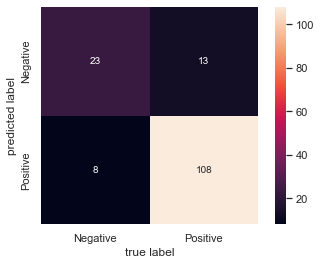


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.8947368421052632
Precision: 0.8947368421052632
Recall: 0.9834710743801653
F1 Score: 0.937007874015748
ROC AUC Score: 0.7659290855771794 

              precision    recall  f1-score   support

    Negative       0.89      0.55      0.68        31
    Positive       0.89      0.98      0.94       121

    accuracy                           0.89       152
   macro avg       0.89      0.77      0.81       152
weighted avg       0.89      0.89      0.88       152

Positive Recall: 0.9834710743801653


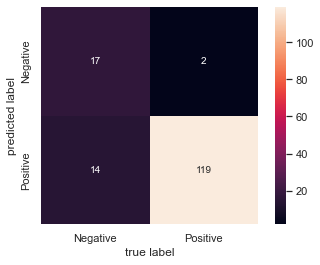


	~~~~	 SVC 	~~~~

Accuracy: 0.8947368421052632
Precision: 0.8832116788321168
Recall: 1.0
F1 Score: 0.937984496124031
ROC AUC Score: 0.7419354838709677 

              precision    recall  f1-score   support

    Negative       1.00      0.48      0.65        31
    Positive       0.88      1.00      0.94       121

    accuracy                           0.89       152
   macro avg       0.94      0.74      0.80       152
weighted avg       0.91      0.89      0.88       152

Positive Recall: 1.0


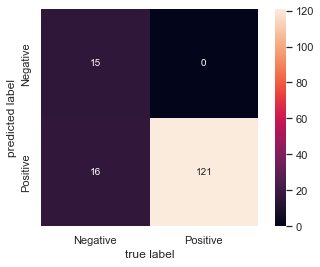


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.7302631578947368
Precision: 0.9347826086956522
Recall: 0.7107438016528925
F1 Score: 0.8075117370892019
ROC AUC Score: 0.7585977072780591 

              precision    recall  f1-score   support

    Negative       0.42      0.81      0.55        31
    Positive       0.93      0.71      0.81       121

    accuracy                           0.73       152
   macro avg       0.68      0.76      0.68       152
weighted avg       0.83      0.73      0.75       152

Positive Recall: 0.7107438016528925


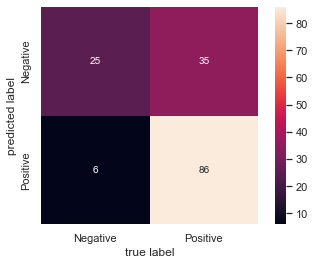




		 *** PCA 200 Components ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.8486842105263158
Precision: 0.8402777777777778
Recall: 1.0
F1 Score: 0.9132075471698113
ROC AUC Score: 0.6290322580645161 

              precision    recall  f1-score   support

    Negative       1.00      0.26      0.41        31
    Positive       0.84      1.00      0.91       121

    accuracy                           0.85       152
   macro avg       0.92      0.63      0.66       152
weighted avg       0.87      0.85      0.81       152

Positive Recall: 1.0


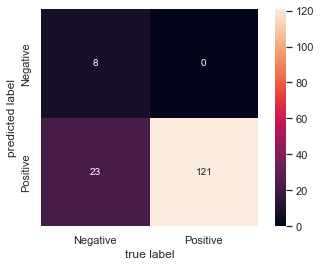


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8618421052631579
Precision: 0.923728813559322
Recall: 0.9008264462809917
F1 Score: 0.9121338912133891
ROC AUC Score: 0.8052519328179152 

              precision    recall  f1-score   support

    Negative       0.65      0.71      0.68        31
    Positive       0.92      0.90      0.91       121

    accuracy                           0.86       152
   macro avg       0.79      0.81      0.79       152
weighted avg       0.87      0.86      0.86       152

Positive Recall: 0.9008264462809917


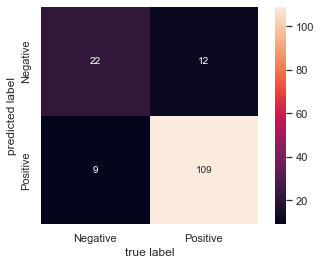


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.8618421052631579
Precision: 0.8571428571428571
Recall: 0.9917355371900827
F1 Score: 0.9195402298850575
ROC AUC Score: 0.673287123433751 

              precision    recall  f1-score   support

    Negative       0.92      0.35      0.51        31
    Positive       0.86      0.99      0.92       121

    accuracy                           0.86       152
   macro avg       0.89      0.67      0.72       152
weighted avg       0.87      0.86      0.84       152

Positive Recall: 0.9917355371900827


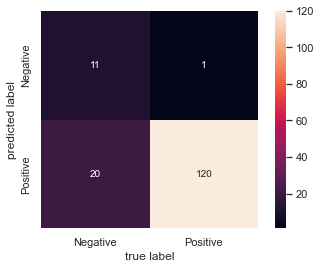


	~~~~	 SVC 	~~~~

Accuracy: 0.8618421052631579
Precision: 0.852112676056338
Recall: 1.0
F1 Score: 0.9201520912547528
ROC AUC Score: 0.6612903225806452 

              precision    recall  f1-score   support

    Negative       1.00      0.32      0.49        31
    Positive       0.85      1.00      0.92       121

    accuracy                           0.86       152
   macro avg       0.93      0.66      0.70       152
weighted avg       0.88      0.86      0.83       152

Positive Recall: 1.0


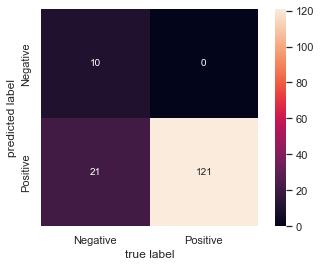


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.8026315789473685
Precision: 0.9252336448598131
Recall: 0.8181818181818182
F1 Score: 0.868421052631579
ROC AUC Score: 0.780058651026393 

              precision    recall  f1-score   support

    Negative       0.51      0.74      0.61        31
    Positive       0.93      0.82      0.87       121

    accuracy                           0.80       152
   macro avg       0.72      0.78      0.74       152
weighted avg       0.84      0.80      0.81       152

Positive Recall: 0.8181818181818182


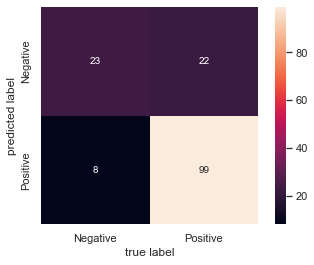




		 *** PCA 250 Components ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.8486842105263158
Precision: 0.8402777777777778
Recall: 1.0
F1 Score: 0.9132075471698113
ROC AUC Score: 0.6290322580645161 

              precision    recall  f1-score   support

    Negative       1.00      0.26      0.41        31
    Positive       0.84      1.00      0.91       121

    accuracy                           0.85       152
   macro avg       0.92      0.63      0.66       152
weighted avg       0.87      0.85      0.81       152

Positive Recall: 1.0


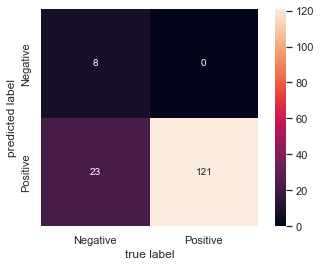


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8421052631578947
Precision: 0.9292035398230089
Recall: 0.8677685950413223
F1 Score: 0.8974358974358975
ROC AUC Score: 0.804852039456145 

              precision    recall  f1-score   support

    Negative       0.59      0.74      0.66        31
    Positive       0.93      0.87      0.90       121

    accuracy                           0.84       152
   macro avg       0.76      0.80      0.78       152
weighted avg       0.86      0.84      0.85       152

Positive Recall: 0.8677685950413223


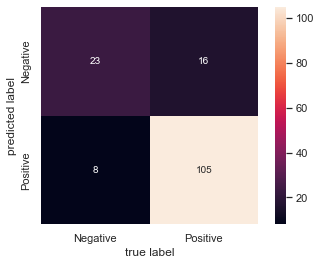


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.881578947368421
Precision: 0.8814814814814815
Recall: 0.9834710743801653
F1 Score: 0.9296875000000001
ROC AUC Score: 0.7336710210610504 

              precision    recall  f1-score   support

    Negative       0.88      0.48      0.62        31
    Positive       0.88      0.98      0.93       121

    accuracy                           0.88       152
   macro avg       0.88      0.73      0.78       152
weighted avg       0.88      0.88      0.87       152

Positive Recall: 0.9834710743801653


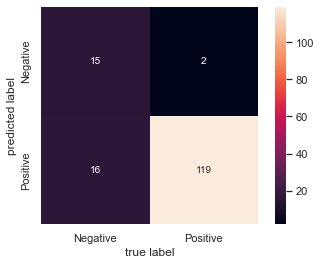


	~~~~	 SVC 	~~~~

Accuracy: 0.8355263157894737
Precision: 0.8287671232876712
Recall: 1.0
F1 Score: 0.9063670411985019
ROC AUC Score: 0.5967741935483871 

              precision    recall  f1-score   support

    Negative       1.00      0.19      0.32        31
    Positive       0.83      1.00      0.91       121

    accuracy                           0.84       152
   macro avg       0.91      0.60      0.62       152
weighted avg       0.86      0.84      0.79       152

Positive Recall: 1.0


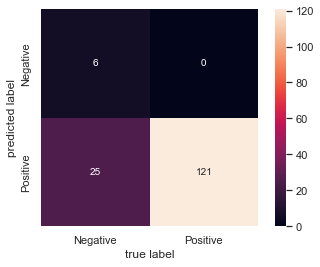


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.8026315789473685
Precision: 0.9174311926605505
Recall: 0.8264462809917356
F1 Score: 0.8695652173913043
ROC AUC Score: 0.7680618501732871 

              precision    recall  f1-score   support

    Negative       0.51      0.71      0.59        31
    Positive       0.92      0.83      0.87       121

    accuracy                           0.80       152
   macro avg       0.71      0.77      0.73       152
weighted avg       0.83      0.80      0.81       152

Positive Recall: 0.8264462809917356


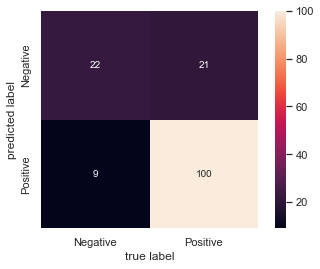




		 *** PCA 300 Components ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.8157894736842105
Precision: 0.8120805369127517
Recall: 1.0
F1 Score: 0.8962962962962964
ROC AUC Score: 0.5483870967741935 

              precision    recall  f1-score   support

    Negative       1.00      0.10      0.18        31
    Positive       0.81      1.00      0.90       121

    accuracy                           0.82       152
   macro avg       0.91      0.55      0.54       152
weighted avg       0.85      0.82      0.75       152

Positive Recall: 1.0


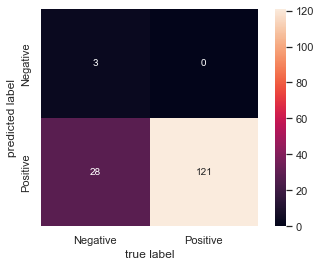


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8486842105263158
Precision: 0.9375
Recall: 0.8677685950413223
F1 Score: 0.9012875536480687
ROC AUC Score: 0.8209810717142095 

              precision    recall  f1-score   support

    Negative       0.60      0.77      0.68        31
    Positive       0.94      0.87      0.90       121

    accuracy                           0.85       152
   macro avg       0.77      0.82      0.79       152
weighted avg       0.87      0.85      0.86       152

Positive Recall: 0.8677685950413223


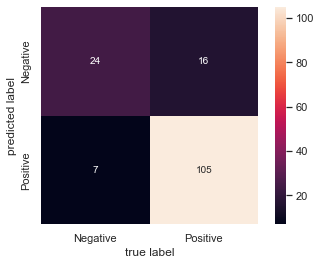


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.8947368421052632
Precision: 0.8888888888888888
Recall: 0.9917355371900827
F1 Score: 0.9375
ROC AUC Score: 0.7539322847240736 

              precision    recall  f1-score   support

    Negative       0.94      0.52      0.67        31
    Positive       0.89      0.99      0.94       121

    accuracy                           0.89       152
   macro avg       0.92      0.75      0.80       152
weighted avg       0.90      0.89      0.88       152

Positive Recall: 0.9917355371900827


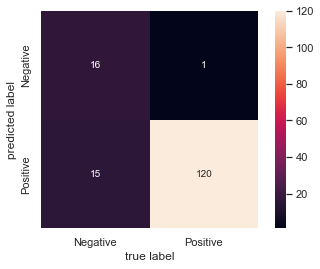


	~~~~	 SVC 	~~~~

Accuracy: 0.8223684210526315
Precision: 0.8175675675675675
Recall: 1.0
F1 Score: 0.8996282527881041
ROC AUC Score: 0.564516129032258 

              precision    recall  f1-score   support

    Negative       1.00      0.13      0.23        31
    Positive       0.82      1.00      0.90       121

    accuracy                           0.82       152
   macro avg       0.91      0.56      0.56       152
weighted avg       0.85      0.82      0.76       152

Positive Recall: 1.0


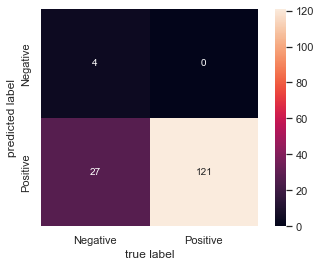


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.7960526315789473
Precision: 0.9090909090909091
Recall: 0.8264462809917356
F1 Score: 0.8658008658008658
ROC AUC Score: 0.7519328179152227 

              precision    recall  f1-score   support

    Negative       0.50      0.68      0.58        31
    Positive       0.91      0.83      0.87       121

    accuracy                           0.80       152
   macro avg       0.70      0.75      0.72       152
weighted avg       0.83      0.80      0.81       152

Positive Recall: 0.8264462809917356


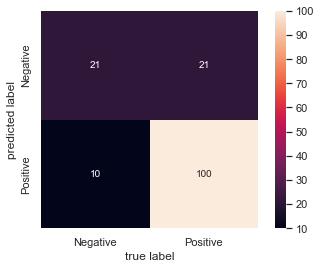




		 *** PCA 350 Components ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.8355263157894737
Precision: 0.8287671232876712
Recall: 1.0
F1 Score: 0.9063670411985019
ROC AUC Score: 0.5967741935483871 

              precision    recall  f1-score   support

    Negative       1.00      0.19      0.32        31
    Positive       0.83      1.00      0.91       121

    accuracy                           0.84       152
   macro avg       0.91      0.60      0.62       152
weighted avg       0.86      0.84      0.79       152

Positive Recall: 1.0


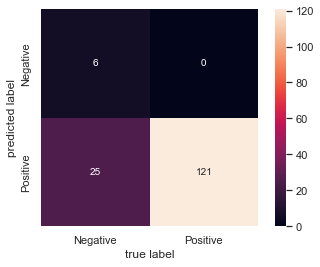


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8421052631578947
Precision: 0.9217391304347826
Recall: 0.8760330578512396
F1 Score: 0.8983050847457628
ROC AUC Score: 0.7928552386030393 

              precision    recall  f1-score   support

    Negative       0.59      0.71      0.65        31
    Positive       0.92      0.88      0.90       121

    accuracy                           0.84       152
   macro avg       0.76      0.79      0.77       152
weighted avg       0.86      0.84      0.85       152

Positive Recall: 0.8760330578512396


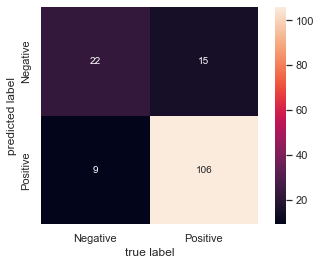


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.881578947368421
Precision: 0.8814814814814815
Recall: 0.9834710743801653
F1 Score: 0.9296875000000001
ROC AUC Score: 0.7336710210610504 

              precision    recall  f1-score   support

    Negative       0.88      0.48      0.62        31
    Positive       0.88      0.98      0.93       121

    accuracy                           0.88       152
   macro avg       0.88      0.73      0.78       152
weighted avg       0.88      0.88      0.87       152

Positive Recall: 0.9834710743801653


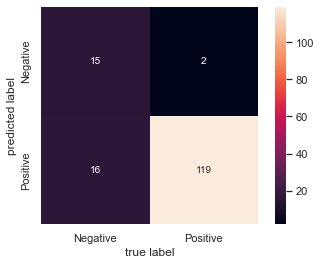


	~~~~	 SVC 	~~~~

Accuracy: 0.8092105263157895
Precision: 0.8066666666666666
Recall: 1.0
F1 Score: 0.8929889298892989
ROC AUC Score: 0.532258064516129 

              precision    recall  f1-score   support

    Negative       1.00      0.06      0.12        31
    Positive       0.81      1.00      0.89       121

    accuracy                           0.81       152
   macro avg       0.90      0.53      0.51       152
weighted avg       0.85      0.81      0.74       152

Positive Recall: 1.0


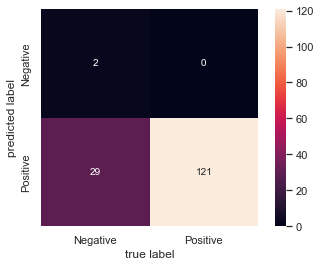


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.7960526315789473
Precision: 0.9090909090909091
Recall: 0.8264462809917356
F1 Score: 0.8658008658008658
ROC AUC Score: 0.7519328179152227 

              precision    recall  f1-score   support

    Negative       0.50      0.68      0.58        31
    Positive       0.91      0.83      0.87       121

    accuracy                           0.80       152
   macro avg       0.70      0.75      0.72       152
weighted avg       0.83      0.80      0.81       152

Positive Recall: 0.8264462809917356


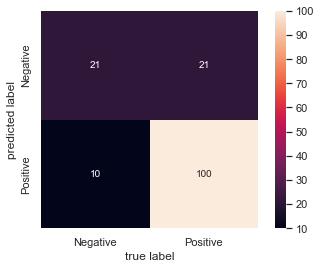




		 *** PCA 400 Components ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.8157894736842105
Precision: 0.8120805369127517
Recall: 1.0
F1 Score: 0.8962962962962964
ROC AUC Score: 0.5483870967741935 

              precision    recall  f1-score   support

    Negative       1.00      0.10      0.18        31
    Positive       0.81      1.00      0.90       121

    accuracy                           0.82       152
   macro avg       0.91      0.55      0.54       152
weighted avg       0.85      0.82      0.75       152

Positive Recall: 1.0


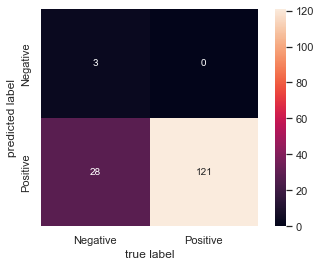


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8157894736842105
Precision: 0.8907563025210085
Recall: 0.8760330578512396
F1 Score: 0.8833333333333333
ROC AUC Score: 0.7283391095707811 

              precision    recall  f1-score   support

    Negative       0.55      0.58      0.56        31
    Positive       0.89      0.88      0.88       121

    accuracy                           0.82       152
   macro avg       0.72      0.73      0.72       152
weighted avg       0.82      0.82      0.82       152

Positive Recall: 0.8760330578512396


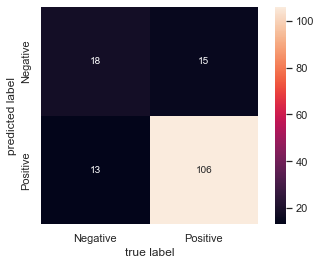


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.875
Precision: 0.8695652173913043
Recall: 0.9917355371900827
F1 Score: 0.9266409266409266
ROC AUC Score: 0.70554518794988 

              precision    recall  f1-score   support

    Negative       0.93      0.42      0.58        31
    Positive       0.87      0.99      0.93       121

    accuracy                           0.88       152
   macro avg       0.90      0.71      0.75       152
weighted avg       0.88      0.88      0.86       152

Positive Recall: 0.9917355371900827


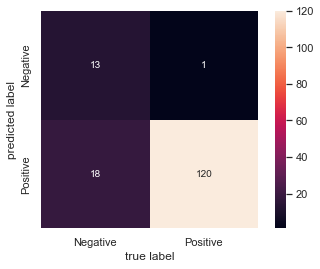


	~~~~	 SVC 	~~~~

Accuracy: 0.8092105263157895
Precision: 0.8066666666666666
Recall: 1.0
F1 Score: 0.8929889298892989
ROC AUC Score: 0.532258064516129 

              precision    recall  f1-score   support

    Negative       1.00      0.06      0.12        31
    Positive       0.81      1.00      0.89       121

    accuracy                           0.81       152
   macro avg       0.90      0.53      0.51       152
weighted avg       0.85      0.81      0.74       152

Positive Recall: 1.0


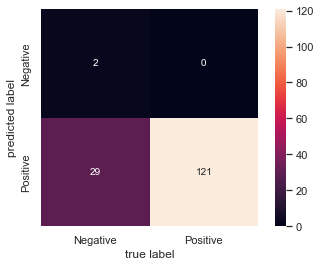


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.7828947368421053
Precision: 0.9
Recall: 0.8181818181818182
F1 Score: 0.8571428571428572
ROC AUC Score: 0.7316715542521994 

              precision    recall  f1-score   support

    Negative       0.48      0.65      0.55        31
    Positive       0.90      0.82      0.86       121

    accuracy                           0.78       152
   macro avg       0.69      0.73      0.70       152
weighted avg       0.81      0.78      0.79       152

Positive Recall: 0.8181818181818182


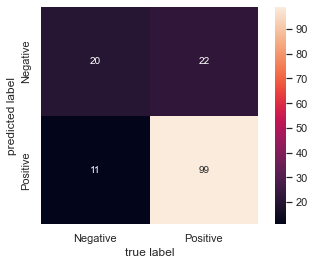




		 *** PCA 450 Components ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.8289473684210527
Precision: 0.8231292517006803
Recall: 1.0
F1 Score: 0.9029850746268657
ROC AUC Score: 0.5806451612903225 

              precision    recall  f1-score   support

    Negative       1.00      0.16      0.28        31
    Positive       0.82      1.00      0.90       121

    accuracy                           0.83       152
   macro avg       0.91      0.58      0.59       152
weighted avg       0.86      0.83      0.78       152

Positive Recall: 1.0


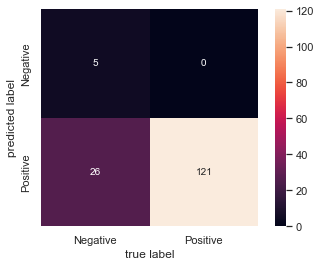


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8157894736842105
Precision: 0.8780487804878049
Recall: 0.8925619834710744
F1 Score: 0.8852459016393442
ROC AUC Score: 0.7043455078645695 

              precision    recall  f1-score   support

    Negative       0.55      0.52      0.53        31
    Positive       0.88      0.89      0.89       121

    accuracy                           0.82       152
   macro avg       0.71      0.70      0.71       152
weighted avg       0.81      0.82      0.81       152

Positive Recall: 0.8925619834710744


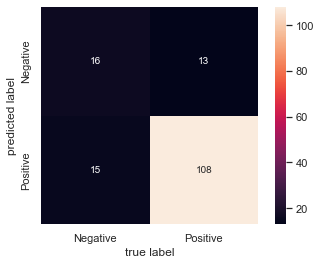


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.875
Precision: 0.875
Recall: 0.9834710743801653
F1 Score: 0.9260700389105058
ROC AUC Score: 0.7175419888029859 

              precision    recall  f1-score   support

    Negative       0.88      0.45      0.60        31
    Positive       0.88      0.98      0.93       121

    accuracy                           0.88       152
   macro avg       0.88      0.72      0.76       152
weighted avg       0.88      0.88      0.86       152

Positive Recall: 0.9834710743801653


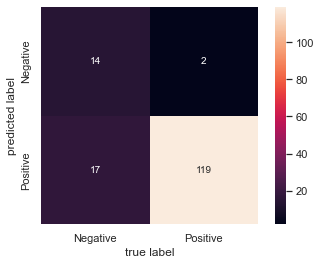


	~~~~	 SVC 	~~~~

Accuracy: 0.7960526315789473
Precision: 0.7960526315789473
Recall: 1.0
F1 Score: 0.8864468864468864
ROC AUC Score: 0.5 

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        31
    Positive       0.80      1.00      0.89       121

    accuracy                           0.80       152
   macro avg       0.40      0.50      0.44       152
weighted avg       0.63      0.80      0.71       152

Positive Recall: 1.0


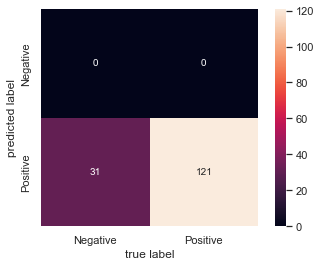


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.7828947368421053
Precision: 0.8928571428571429
Recall: 0.8264462809917356
F1 Score: 0.8583690987124464
ROC AUC Score: 0.7196747533990936 

              precision    recall  f1-score   support

    Negative       0.47      0.61      0.54        31
    Positive       0.89      0.83      0.86       121

    accuracy                           0.78       152
   macro avg       0.68      0.72      0.70       152
weighted avg       0.81      0.78      0.79       152

Positive Recall: 0.8264462809917356


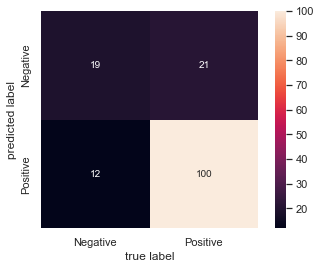




		 *** PCA 500 Components ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.8026315789473685
Precision: 0.8013245033112583
Recall: 1.0
F1 Score: 0.8897058823529412
ROC AUC Score: 0.5161290322580645 

              precision    recall  f1-score   support

    Negative       1.00      0.03      0.06        31
    Positive       0.80      1.00      0.89       121

    accuracy                           0.80       152
   macro avg       0.90      0.52      0.48       152
weighted avg       0.84      0.80      0.72       152

Positive Recall: 1.0


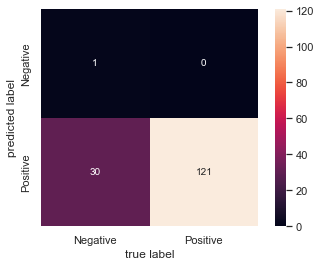


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.7960526315789473
Precision: 0.8629032258064516
Recall: 0.8842975206611571
F1 Score: 0.8734693877551021
ROC AUC Score: 0.6679552119434817 

              precision    recall  f1-score   support

    Negative       0.50      0.45      0.47        31
    Positive       0.86      0.88      0.87       121

    accuracy                           0.80       152
   macro avg       0.68      0.67      0.67       152
weighted avg       0.79      0.80      0.79       152

Positive Recall: 0.8842975206611571


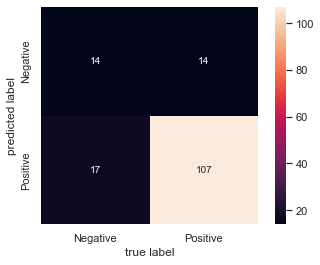


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.875
Precision: 0.8695652173913043
Recall: 0.9917355371900827
F1 Score: 0.9266409266409266
ROC AUC Score: 0.70554518794988 

              precision    recall  f1-score   support

    Negative       0.93      0.42      0.58        31
    Positive       0.87      0.99      0.93       121

    accuracy                           0.88       152
   macro avg       0.90      0.71      0.75       152
weighted avg       0.88      0.88      0.86       152

Positive Recall: 0.9917355371900827


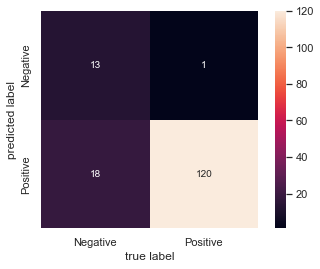


	~~~~	 SVC 	~~~~

Accuracy: 0.7960526315789473
Precision: 0.7960526315789473
Recall: 1.0
F1 Score: 0.8864468864468864
ROC AUC Score: 0.5 

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        31
    Positive       0.80      1.00      0.89       121

    accuracy                           0.80       152
   macro avg       0.40      0.50      0.44       152
weighted avg       0.63      0.80      0.71       152

Positive Recall: 1.0


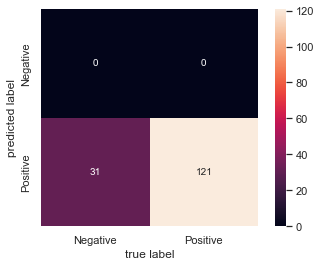


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.7631578947368421
Precision: 0.8828828828828829
Recall: 0.8099173553719008
F1 Score: 0.8448275862068966
ROC AUC Score: 0.6952812583311117 

              precision    recall  f1-score   support

    Negative       0.44      0.58      0.50        31
    Positive       0.88      0.81      0.84       121

    accuracy                           0.76       152
   macro avg       0.66      0.70      0.67       152
weighted avg       0.79      0.76      0.77       152

Positive Recall: 0.8099173553719008


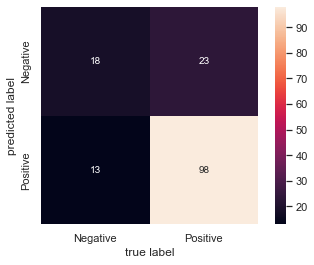




		 *** PCA 550 Components ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.8026315789473685
Precision: 0.8013245033112583
Recall: 1.0
F1 Score: 0.8897058823529412
ROC AUC Score: 0.5161290322580645 

              precision    recall  f1-score   support

    Negative       1.00      0.03      0.06        31
    Positive       0.80      1.00      0.89       121

    accuracy                           0.80       152
   macro avg       0.90      0.52      0.48       152
weighted avg       0.84      0.80      0.72       152

Positive Recall: 1.0


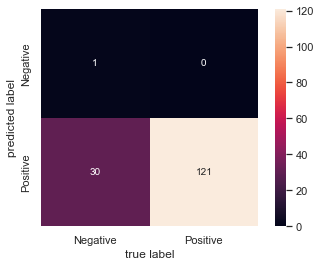


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8289473684210527
Precision: 0.8682170542635659
Recall: 0.9256198347107438
F1 Score: 0.896
ROC AUC Score: 0.6886163689682752 

              precision    recall  f1-score   support

    Negative       0.61      0.45      0.52        31
    Positive       0.87      0.93      0.90       121

    accuracy                           0.83       152
   macro avg       0.74      0.69      0.71       152
weighted avg       0.82      0.83      0.82       152

Positive Recall: 0.9256198347107438


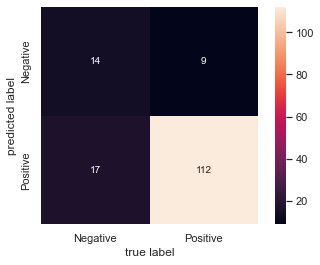


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.881578947368421
Precision: 0.8759124087591241
Recall: 0.9917355371900827
F1 Score: 0.9302325581395349
ROC AUC Score: 0.7216742202079446 

              precision    recall  f1-score   support

    Negative       0.93      0.45      0.61        31
    Positive       0.88      0.99      0.93       121

    accuracy                           0.88       152
   macro avg       0.90      0.72      0.77       152
weighted avg       0.89      0.88      0.86       152

Positive Recall: 0.9917355371900827


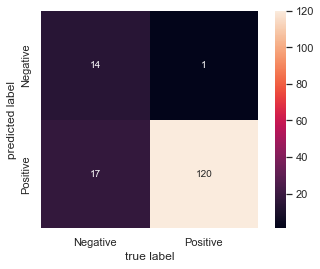


	~~~~	 SVC 	~~~~

Accuracy: 0.7960526315789473
Precision: 0.7960526315789473
Recall: 1.0
F1 Score: 0.8864468864468864
ROC AUC Score: 0.5 

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        31
    Positive       0.80      1.00      0.89       121

    accuracy                           0.80       152
   macro avg       0.40      0.50      0.44       152
weighted avg       0.63      0.80      0.71       152

Positive Recall: 1.0


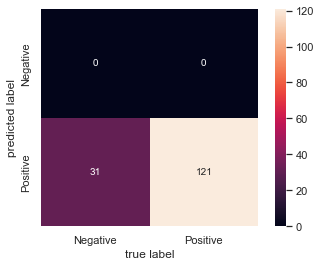


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.7763157894736842
Precision: 0.8990825688073395
Recall: 0.8099173553719008
F1 Score: 0.8521739130434783
ROC AUC Score: 0.7275393228472407 

              precision    recall  f1-score   support

    Negative       0.47      0.65      0.54        31
    Positive       0.90      0.81      0.85       121

    accuracy                           0.78       152
   macro avg       0.68      0.73      0.70       152
weighted avg       0.81      0.78      0.79       152

Positive Recall: 0.8099173553719008


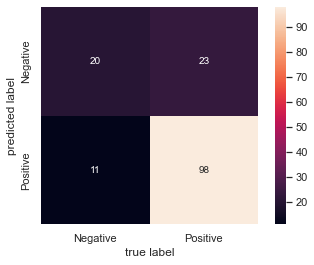




		 *** PCA 600 Components ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.8026315789473685
Precision: 0.8013245033112583
Recall: 1.0
F1 Score: 0.8897058823529412
ROC AUC Score: 0.5161290322580645 

              precision    recall  f1-score   support

    Negative       1.00      0.03      0.06        31
    Positive       0.80      1.00      0.89       121

    accuracy                           0.80       152
   macro avg       0.90      0.52      0.48       152
weighted avg       0.84      0.80      0.72       152

Positive Recall: 1.0


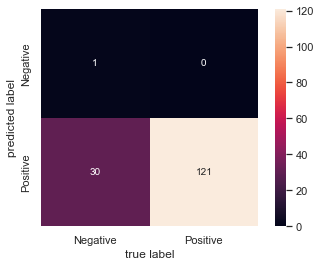


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8157894736842105
Precision: 0.8549618320610687
Recall: 0.9256198347107438
F1 Score: 0.8888888888888888
ROC AUC Score: 0.6563583044521462 

              precision    recall  f1-score   support

    Negative       0.57      0.39      0.46        31
    Positive       0.85      0.93      0.89       121

    accuracy                           0.82       152
   macro avg       0.71      0.66      0.68       152
weighted avg       0.80      0.82      0.80       152

Positive Recall: 0.9256198347107438


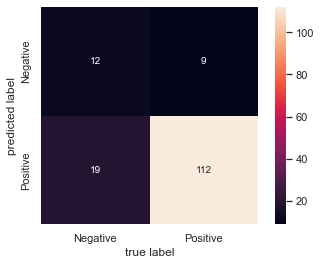


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.868421052631579
Precision: 0.8686131386861314
Recall: 0.9834710743801653
F1 Score: 0.922480620155039
ROC AUC Score: 0.7014129565449214 

              precision    recall  f1-score   support

    Negative       0.87      0.42      0.57        31
    Positive       0.87      0.98      0.92       121

    accuracy                           0.87       152
   macro avg       0.87      0.70      0.74       152
weighted avg       0.87      0.87      0.85       152

Positive Recall: 0.9834710743801653


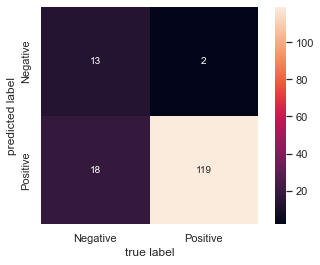


	~~~~	 SVC 	~~~~

Accuracy: 0.7960526315789473
Precision: 0.7960526315789473
Recall: 1.0
F1 Score: 0.8864468864468864
ROC AUC Score: 0.5 

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        31
    Positive       0.80      1.00      0.89       121

    accuracy                           0.80       152
   macro avg       0.40      0.50      0.44       152
weighted avg       0.63      0.80      0.71       152

Positive Recall: 1.0


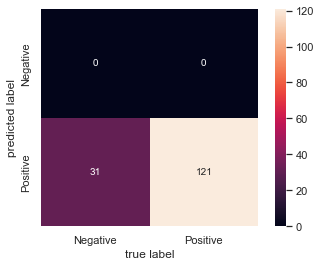


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.7763157894736842
Precision: 0.8918918918918919
Recall: 0.8181818181818182
F1 Score: 0.853448275862069
ROC AUC Score: 0.7155425219941349 

              precision    recall  f1-score   support

    Negative       0.46      0.61      0.53        31
    Positive       0.89      0.82      0.85       121

    accuracy                           0.78       152
   macro avg       0.68      0.72      0.69       152
weighted avg       0.80      0.78      0.79       152

Positive Recall: 0.8181818181818182


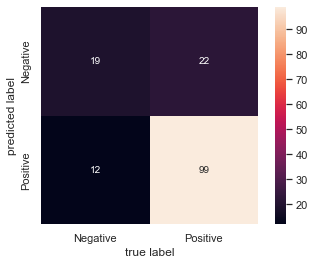




		 *** PCA 650 Components ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.8092105263157895
Precision: 0.8066666666666666
Recall: 1.0
F1 Score: 0.8929889298892989
ROC AUC Score: 0.532258064516129 

              precision    recall  f1-score   support

    Negative       1.00      0.06      0.12        31
    Positive       0.81      1.00      0.89       121

    accuracy                           0.81       152
   macro avg       0.90      0.53      0.51       152
weighted avg       0.85      0.81      0.74       152

Positive Recall: 1.0


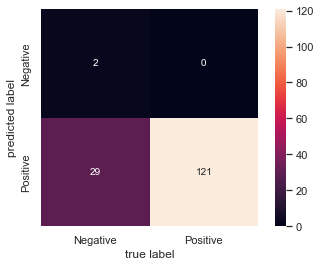


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.7894736842105263
Precision: 0.8248175182481752
Recall: 0.9338842975206612
F1 Score: 0.875968992248062
ROC AUC Score: 0.5798453745667822 

              precision    recall  f1-score   support

    Negative       0.47      0.23      0.30        31
    Positive       0.82      0.93      0.88       121

    accuracy                           0.79       152
   macro avg       0.65      0.58      0.59       152
weighted avg       0.75      0.79      0.76       152

Positive Recall: 0.9338842975206612


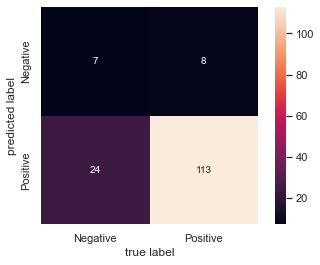


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.868421052631579
Precision: 0.8633093525179856
Recall: 0.9917355371900827
F1 Score: 0.9230769230769231
ROC AUC Score: 0.6894161556918155 

              precision    recall  f1-score   support

    Negative       0.92      0.39      0.55        31
    Positive       0.86      0.99      0.92       121

    accuracy                           0.87       152
   macro avg       0.89      0.69      0.73       152
weighted avg       0.88      0.87      0.85       152

Positive Recall: 0.9917355371900827


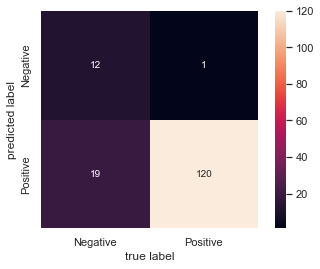


	~~~~	 SVC 	~~~~

Accuracy: 0.7960526315789473
Precision: 0.7960526315789473
Recall: 1.0
F1 Score: 0.8864468864468864
ROC AUC Score: 0.5 

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        31
    Positive       0.80      1.00      0.89       121

    accuracy                           0.80       152
   macro avg       0.40      0.50      0.44       152
weighted avg       0.63      0.80      0.71       152

Positive Recall: 1.0


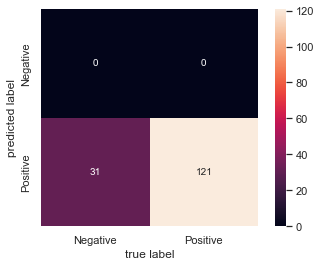


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.7763157894736842
Precision: 0.8717948717948718
Recall: 0.8429752066115702
F1 Score: 0.8571428571428571
ROC AUC Score: 0.6795521194348173 

              precision    recall  f1-score   support

    Negative       0.46      0.52      0.48        31
    Positive       0.87      0.84      0.86       121

    accuracy                           0.78       152
   macro avg       0.66      0.68      0.67       152
weighted avg       0.79      0.78      0.78       152

Positive Recall: 0.8429752066115702


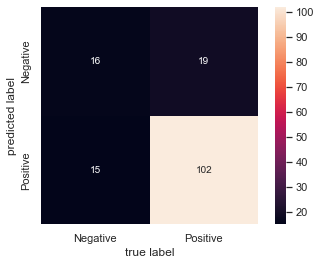




		 *** PCA 700 Components ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.8092105263157895
Precision: 0.8066666666666666
Recall: 1.0
F1 Score: 0.8929889298892989
ROC AUC Score: 0.532258064516129 

              precision    recall  f1-score   support

    Negative       1.00      0.06      0.12        31
    Positive       0.81      1.00      0.89       121

    accuracy                           0.81       152
   macro avg       0.90      0.53      0.51       152
weighted avg       0.85      0.81      0.74       152

Positive Recall: 1.0


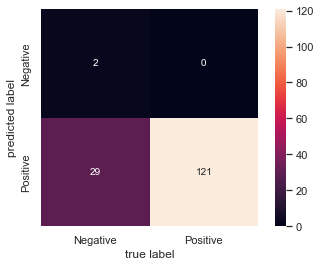


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.8223684210526315
Precision: 0.8309859154929577
Recall: 0.9752066115702479
F1 Score: 0.8973384030418251
ROC AUC Score: 0.6005065315915755 

              precision    recall  f1-score   support

    Negative       0.70      0.23      0.34        31
    Positive       0.83      0.98      0.90       121

    accuracy                           0.82       152
   macro avg       0.77      0.60      0.62       152
weighted avg       0.80      0.82      0.78       152

Positive Recall: 0.9752066115702479


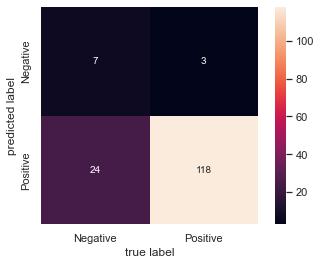


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.8618421052631579
Precision: 0.8623188405797102
Recall: 0.9834710743801653
F1 Score: 0.918918918918919
ROC AUC Score: 0.6852839242868569 

              precision    recall  f1-score   support

    Negative       0.86      0.39      0.53        31
    Positive       0.86      0.98      0.92       121

    accuracy                           0.86       152
   macro avg       0.86      0.69      0.73       152
weighted avg       0.86      0.86      0.84       152

Positive Recall: 0.9834710743801653


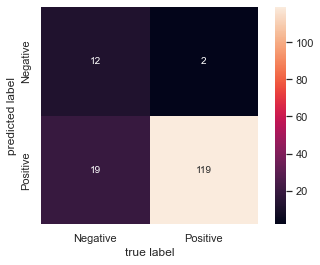


	~~~~	 SVC 	~~~~

Accuracy: 0.7960526315789473
Precision: 0.7960526315789473
Recall: 1.0
F1 Score: 0.8864468864468864
ROC AUC Score: 0.5 

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        31
    Positive       0.80      1.00      0.89       121

    accuracy                           0.80       152
   macro avg       0.40      0.50      0.44       152
weighted avg       0.63      0.80      0.71       152

Positive Recall: 1.0


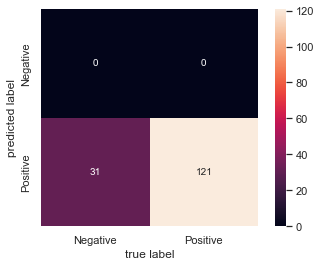


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.7894736842105263
Precision: 0.8739495798319328
Recall: 0.859504132231405
F1 Score: 0.8666666666666667
ROC AUC Score: 0.6878165822447347 

              precision    recall  f1-score   support

    Negative       0.48      0.52      0.50        31
    Positive       0.87      0.86      0.87       121

    accuracy                           0.79       152
   macro avg       0.68      0.69      0.68       152
weighted avg       0.79      0.79      0.79       152

Positive Recall: 0.859504132231405


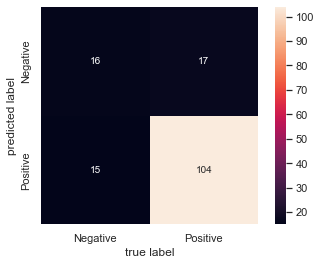




		 *** PCA 750 Components ***



	~~~~	 RandomForestClassifier 	~~~~

Accuracy: 0.8157894736842105
Precision: 0.8120805369127517
Recall: 1.0
F1 Score: 0.8962962962962964
ROC AUC Score: 0.5483870967741935 

              precision    recall  f1-score   support

    Negative       1.00      0.10      0.18        31
    Positive       0.81      1.00      0.90       121

    accuracy                           0.82       152
   macro avg       0.91      0.55      0.54       152
weighted avg       0.85      0.82      0.75       152

Positive Recall: 1.0


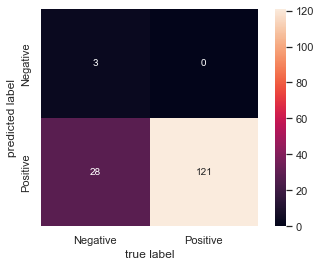


	~~~~	 LogisticRegression 	~~~~

Accuracy: 0.7960526315789473
Precision: 0.7960526315789473
Recall: 1.0
F1 Score: 0.8864468864468864
ROC AUC Score: 0.5 

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        31
    Positive       0.80      1.00      0.89       121

    accuracy                           0.80       152
   macro avg       0.40      0.50      0.44       152
weighted avg       0.63      0.80      0.71       152

Positive Recall: 1.0


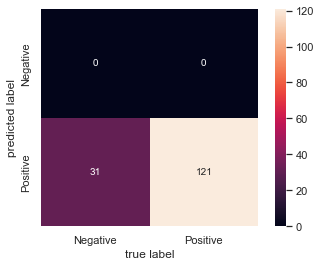


	~~~~	 GradientBoostingClassifier 	~~~~

Accuracy: 0.868421052631579
Precision: 0.8633093525179856
Recall: 0.9917355371900827
F1 Score: 0.9230769230769231
ROC AUC Score: 0.6894161556918155 

              precision    recall  f1-score   support

    Negative       0.92      0.39      0.55        31
    Positive       0.86      0.99      0.92       121

    accuracy                           0.87       152
   macro avg       0.89      0.69      0.73       152
weighted avg       0.88      0.87      0.85       152

Positive Recall: 0.9917355371900827


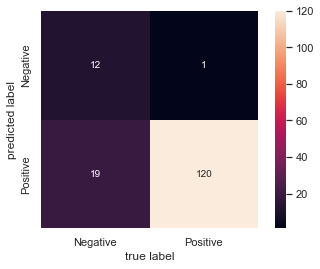


	~~~~	 SVC 	~~~~

Accuracy: 0.7960526315789473
Precision: 0.7960526315789473
Recall: 1.0
F1 Score: 0.8864468864468864
ROC AUC Score: 0.5 

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        31
    Positive       0.80      1.00      0.89       121

    accuracy                           0.80       152
   macro avg       0.40      0.50      0.44       152
weighted avg       0.63      0.80      0.71       152

Positive Recall: 1.0


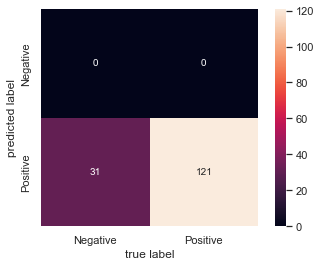


	~~~~	 GaussianNB 	~~~~

Accuracy: 0.8092105263157895
Precision: 0.8770491803278688
Recall: 0.8842975206611571
F1 Score: 0.8806584362139916
ROC AUC Score: 0.7002132764596107 

              precision    recall  f1-score   support

    Negative       0.53      0.52      0.52        31
    Positive       0.88      0.88      0.88       121

    accuracy                           0.81       152
   macro avg       0.71      0.70      0.70       152
weighted avg       0.81      0.81      0.81       152

Positive Recall: 0.8842975206611571


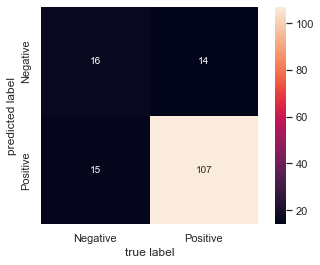

In [21]:

pd_data = get_data(pd_csv)

print('\n\n\n\t\t *** ALL Features ***\n\n\n')

evaluate_models(pd_data,
    [RandomForestClassifier(), 
     LogisticRegression(max_iter=1000),
     GradientBoostingClassifier(),
     SVC(),
     GaussianNB()])


for top in np.arange(50, 751, 50):
    print('\n\n\n\t\t *** TOP', top, 'Features ***\n\n')

    pd_data_top = get_important(pd_data, top)

    evaluate_models(pd_data_top,
        [RandomForestClassifier(), 
        LogisticRegression(max_iter=1000),
        GradientBoostingClassifier(),
        SVC(),
        GaussianNB()])
    
for components in np.arange(50, 751, 50):
    print('\n\n\n\t\t *** PCA', components, 'Components ***\n\n')

    pd_data_pcs = get_pca(pd_data, components)

    evaluate_models(pd_data_pcs,
        [RandomForestClassifier(), 
        LogisticRegression(max_iter=1000),
        GradientBoostingClassifier(),
        SVC(),
        GaussianNB()])
     